# Projet 7 : Implémentation d'un modèle de scoring

## <a name="C0"> Mission 1 - Élaborer le modèle de scoring<a>
    
## Partie 1 : Feature Engineering

### Problématique :
- Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
- L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.)

**Missions :**
<ol>   
<li> Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.</li>
<li> Analyser les features qui contribuent le plus au modèle, d'une manière générale (feature importance globale) et au niveau d'un client (feature importance locale), afin, dans un soucis de transparence, de permettre à un chargé d'études de mieux comprendre le score attribué par le modèle.</li>
<li> Mettre en production le modèle de scoring de prédiction à l'aide d'une API et réaliser une interface de test de cette API.</li>
<li> Mettre en œuvre une approche globale MLOps de bout en bout, du tracking des expérimentations à l'analyse en production du data drift.</li>
</ol>    
    
    
Pour ce notebook, je me suis appuyé sur ces sources Kaggle :
- [Kernel Kaggle 1](https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook#Feature-Engineering)
- [Kernel Kaggle 2](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script)
- [kernel Kaggle 3](https://www.kaggle.com/code/hikmetsezen/micro-model-174-features-0-8-auc-on-home-credit)

In [81]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Setting seaborn style
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
import re

# Analyse exploratoire des données

In [3]:
# Import the datasets

application_train = pd.read_csv("application_train.csv")
application_test = pd.read_csv("application_test.csv")
bureau_data = pd.read_csv("bureau.csv")
bureau_balance_data = pd.read_csv("bureau_balance.csv")
credit_card_balance_data = pd.read_csv("credit_card_balance.csv")
installments_payments_data = pd.read_csv("installments_payments.csv")
POS_CASH_balance_data = pd.read_csv("POS_CASH_balance.csv")
HomeCredit_columns_description_data = pd.read_csv("HomeCredit_columns_description.csv",encoding="latin")
previous_application_data = pd.read_csv("previous_application.csv")
sample_submission_data = pd.read_csv("sample_submission.csv")

display("application_train :",application_train)
print()
display("application_test :",application_test)
print()
display("bureau :",bureau_data)
print()
display("bureau_balance :",bureau_balance_data)
print()
display("credit_card_balance :",credit_card_balance_data)
print()
display("installments_payments :",installments_payments_data)
print()
display("POS_CASH_balance :",POS_CASH_balance_data)
print()
display("HomeCredit_columns_description :",HomeCredit_columns_description_data)
print()
display("previous_application :",previous_application_data)
print()
display("sample_submission :",sample_submission_data)

'application_train :'

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


'application_test :'

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


'bureau :'

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


'bureau_balance :'

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


'credit_card_balance :'

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


'installments_payments :'

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


'POS_CASH_balance :'

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


'HomeCredit_columns_description :'

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


'previous_application :'

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


'sample_submission :'

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5
...,...,...
48739,456221,0.5
48740,456222,0.5
48741,456223,0.5
48742,456224,0.5


In [4]:
# List of datasets
liste_dfs = [application_train,application_test,bureau_data,bureau_balance_data,credit_card_balance_data,
             installments_payments_data,POS_CASH_balance_data,HomeCredit_columns_description_data,previous_application_data,
            sample_submission_data]

# List of datasets names
names_dfs = ["application_train","application_test","bureau","bureau_balance","credit_card_balance","installments_payments",
             "POS_CASH_balance","HomeCredit_columns_description","previous_application","sample_submission"]

# The shapes of the datasets
for df,df_name in zip(liste_dfs,names_dfs) :
    print(f"Le jeux de données '{df_name}' est de dimension {df.shape}")
    print()

Le jeux de données 'application_train' est de dimension (307511, 122)

Le jeux de données 'application_test' est de dimension (48744, 121)

Le jeux de données 'bureau' est de dimension (1716428, 17)

Le jeux de données 'bureau_balance' est de dimension (27299925, 3)

Le jeux de données 'credit_card_balance' est de dimension (3840312, 23)

Le jeux de données 'installments_payments' est de dimension (13605401, 8)

Le jeux de données 'POS_CASH_balance' est de dimension (10001358, 8)

Le jeux de données 'HomeCredit_columns_description' est de dimension (219, 5)

Le jeux de données 'previous_application' est de dimension (1670214, 37)

Le jeux de données 'sample_submission' est de dimension (48744, 2)



In [5]:
# Primary key
display("Is 'SK_ID_CURR' a unique key ?",application_train.SK_ID_CURR.is_unique)

"Is 'SK_ID_CURR' a unique key ?"

True

In [6]:
# application data list of columns
display(list(application_train.columns))
print()
print("-"*100)
print()
# Number of each type of column
display(application_train.dtypes.value_counts())

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A


----------------------------------------------------------------------------------------------------



float64    65
int64      41
object     16
dtype: int64

### Traitement des valeurs manquantes

In [7]:
# Rate of NA values for all features
for df,df_name in zip(liste_dfs,names_dfs):
   
    display(f"Taux de valeurs manquantes du jeu de données '{df_name}' :",
            (df.isnull().mean(axis=0)*100).reset_index().rename(columns={"index": "Cols",
                                                         0: "NA_rate"}).sort_values(by="NA_rate",ascending=False))
    print()

"Taux de valeurs manquantes du jeu de données 'application_train' :"

,Cols,NA_rate
76,COMMONAREA_MEDI,69.872297
48,COMMONAREA_AVG,69.872297
62,COMMONAREA_MODE,69.872297
70,NONLIVINGAPARTMENTS_MODE,69.432963
56,NONLIVINGAPARTMENTS_AVG,69.432963
...,...,...
15,NAME_HOUSING_TYPE,0.000000
14,NAME_FAMILY_STATUS,0.000000
13,NAME_EDUCATION_TYPE,0.000000
12,NAME_INCOME_TYPE,0.000000


"Taux de valeurs manquantes du jeu de données 'application_test' :"

,Cols,NA_rate
47,COMMONAREA_AVG,68.716150
61,COMMONAREA_MODE,68.716150
75,COMMONAREA_MEDI,68.716150
55,NONLIVINGAPARTMENTS_AVG,68.412523
69,NONLIVINGAPARTMENTS_MODE,68.412523
...,...,...
14,NAME_HOUSING_TYPE,0.000000
13,NAME_FAMILY_STATUS,0.000000
12,NAME_EDUCATION_TYPE,0.000000
11,NAME_INCOME_TYPE,0.000000


"Taux de valeurs manquantes du jeu de données 'bureau' :"

,Cols,NA_rate
16,AMT_ANNUITY,71.473490
8,AMT_CREDIT_MAX_OVERDUE,65.513264
7,DAYS_ENDDATE_FACT,36.916958
12,AMT_CREDIT_SUM_LIMIT,34.477415
11,AMT_CREDIT_SUM_DEBT,15.011932
6,DAYS_CREDIT_ENDDATE,6.149573
10,AMT_CREDIT_SUM,0.000757
2,CREDIT_ACTIVE,0.000000
3,CREDIT_CURRENCY,0.000000
4,DAYS_CREDIT,0.000000


"Taux de valeurs manquantes du jeu de données 'bureau_balance' :"

,Cols,NA_rate
0,SK_ID_BUREAU,0.0
1,MONTHS_BALANCE,0.0
2,STATUS,0.0


"Taux de valeurs manquantes du jeu de données 'credit_card_balance' :"

,Cols,NA_rate
10,AMT_PAYMENT_CURRENT,19.998063
5,AMT_DRAWINGS_ATM_CURRENT,19.524872
18,CNT_DRAWINGS_POS_CURRENT,19.524872
7,AMT_DRAWINGS_OTHER_CURRENT,19.524872
8,AMT_DRAWINGS_POS_CURRENT,19.524872
17,CNT_DRAWINGS_OTHER_CURRENT,19.524872
15,CNT_DRAWINGS_ATM_CURRENT,19.524872
19,CNT_INSTALMENT_MATURE_CUM,7.948208
9,AMT_INST_MIN_REGULARITY,7.948208
0,SK_ID_PREV,0.000000


"Taux de valeurs manquantes du jeu de données 'installments_payments' :"

,Cols,NA_rate
5,DAYS_ENTRY_PAYMENT,0.021352
7,AMT_PAYMENT,0.021352
0,SK_ID_PREV,0.000000
1,SK_ID_CURR,0.000000
2,NUM_INSTALMENT_VERSION,0.000000
3,NUM_INSTALMENT_NUMBER,0.000000
4,DAYS_INSTALMENT,0.000000
6,AMT_INSTALMENT,0.000000


"Taux de valeurs manquantes du jeu de données 'POS_CASH_balance' :"

,Cols,NA_rate
4,CNT_INSTALMENT_FUTURE,0.260835
3,CNT_INSTALMENT,0.260675
0,SK_ID_PREV,0.000000
1,SK_ID_CURR,0.000000
2,MONTHS_BALANCE,0.000000
5,NAME_CONTRACT_STATUS,0.000000
6,SK_DPD,0.000000
7,SK_DPD_DEF,0.000000


"Taux de valeurs manquantes du jeu de données 'HomeCredit_columns_description' :"

,Cols,NA_rate
4,Special,60.730594
0,Unnamed: 0,0.000000
1,Table,0.000000
2,Row,0.000000
3,Description,0.000000


"Taux de valeurs manquantes du jeu de données 'previous_application' :"

,Cols,NA_rate
14,RATE_INTEREST_PRIVILEGED,99.643698
13,RATE_INTEREST_PRIMARY,99.643698
6,AMT_DOWN_PAYMENT,53.636480
12,RATE_DOWN_PAYMENT,53.636480
20,NAME_TYPE_SUITE,49.119754
36,NFLAG_INSURED_ON_APPROVAL,40.298129
35,DAYS_TERMINATION,40.298129
34,DAYS_LAST_DUE,40.298129
33,DAYS_LAST_DUE_1ST_VERSION,40.298129
32,DAYS_FIRST_DUE,40.298129


"Taux de valeurs manquantes du jeu de données 'sample_submission' :"

,Cols,NA_rate
0,SK_ID_CURR,0.0
1,TARGET,0.0


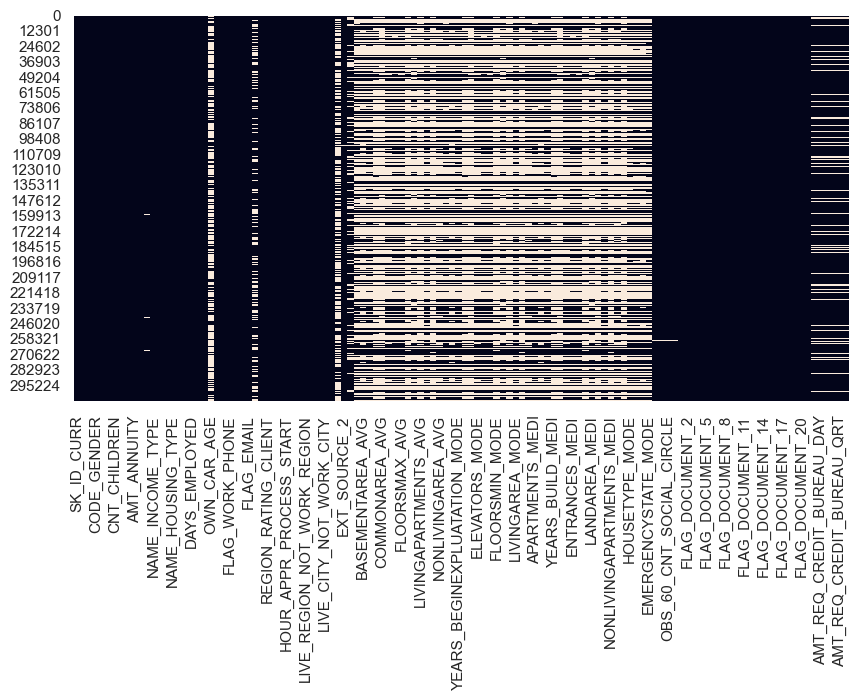

In [12]:
# NA heatmap
plt.figure(figsize=(10,5))
sns.heatmap(application_train.isna(), cbar= False)
plt.show()

* Nous constatons une forte présence de valeurs manquantes. Nous allons d'abord supprimer les colonnes qui ont un taux de valeurs manquantes supérieur à 50%. Nous allons, pour les autres colonnes, effectuer une imputaton par la moyenne, médianne ou par les voisins les plus proches à l'aide des méthodes SimpleImputer ou KNNImputer.

**Suppression des colonnes qui ont plus de 50% de valeurs manquantes et imputation dpar la moyenne pour les autres colonnes**

In [8]:
# Remove columns that contain 50+% of NA 
# Bureau
bureau_data = bureau_data.dropna(thresh=len(bureau_data) * 0.5, axis=1)

# previous_application_data
previous_application_data = previous_application_data.dropna(thresh=len(previous_application_data) * 0.5, axis=1)

# application train
train = application_train.copy()
train = train.dropna(thresh=len(train) * 0.5, axis=1)
# application test
test = application_test.copy()
test = test.dropna(thresh=len(test) * 0.5, axis=1)

display(train.shape,test.shape)

(307511, 81)

(48744, 92)

In [9]:
# Application test data missing values 
(train.isnull().mean(axis=0)*100).reset_index().rename(columns={"index": "Columns", 
                                          0: "% NA values"}).sort_values(by="% NA values",ascending=False).head(30)

,Columns,% NA values
43,FLOORSMAX_AVG,49.760822
45,FLOORSMAX_MODE,49.760822
47,FLOORSMAX_MEDI,49.760822
42,YEARS_BEGINEXPLUATATION_AVG,48.781019
44,YEARS_BEGINEXPLUATATION_MODE,48.781019
46,YEARS_BEGINEXPLUATATION_MEDI,48.781019
48,TOTALAREA_MODE,48.268517
49,EMERGENCYSTATE_MODE,47.398304
27,OCCUPATION_TYPE,31.345545
41,EXT_SOURCE_3,19.825307


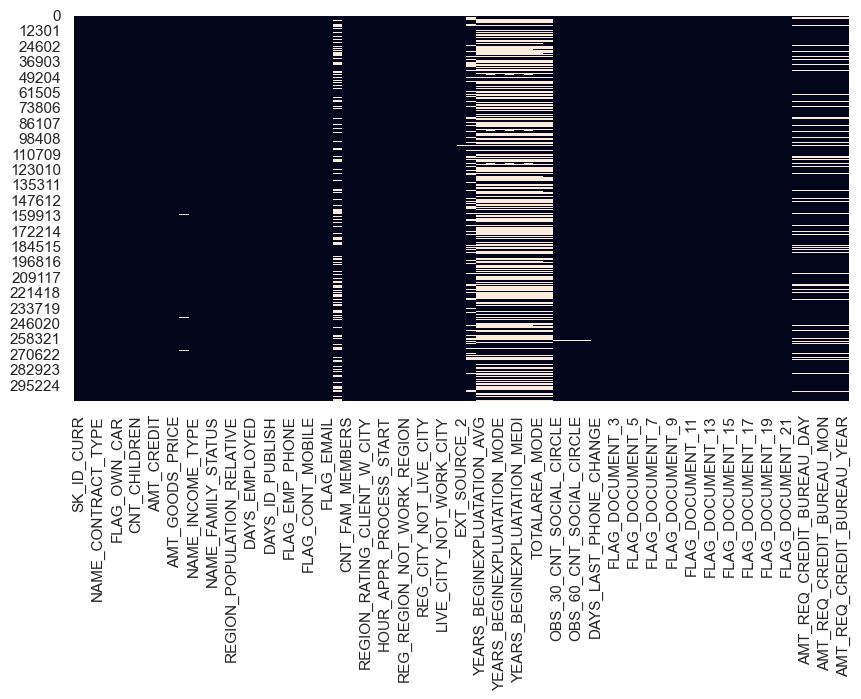

In [15]:
# NA heatmap
plt.figure(figsize=(10,5))
sns.heatmap(train.isna(), cbar= False)
plt.show()

## Analyse descriptive

### Analyse de la TARGET

> La variable TARGET est ce qu'on nous demande de prédire : soit un 0 pour le prêt remboursé à temps, ou 1 pour le client ayant rencontré des difficultés de paiement.

'Distribution of the Target :'

0    282686
1     24825
Name: TARGET, dtype: int64

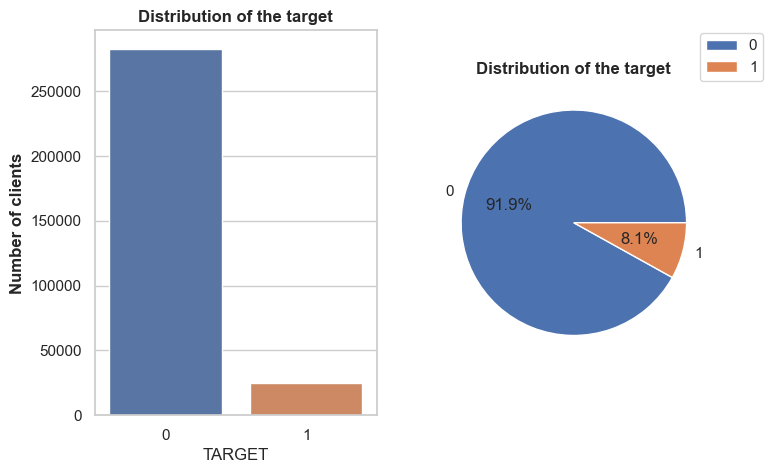

In [16]:
# Distribution of the TARGET
display("Distribution of the Target :",train.TARGET.value_counts())
print()

# Plotting the distribution of the TARGET
fig, axes = plt.subplots(1,2,figsize=(8,5))

sns.countplot(x="TARGET",data=train,ax=axes[0])
axes[0].set_ylabel("Number of clients",fontweight="bold")
axes[0].set_title("Distribution of the target",fontweight="bold")

axes[1].pie(train["TARGET"].value_counts(),labels=train["TARGET"].value_counts().index,autopct="%1.1f%%")
axes[1].set_title("Distribution of the target",fontweight="bold")
axes[1].legend(bbox_to_anchor=(1.2,1.2))

plt.show() 

* Nous avons ici un problème de déséquilibre de classe.
* Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés.
* Ce déséquilibre pourrait être très problématique pour no prédictions futurs.

## Analyse des variables catégorielles

In [17]:
# Number of unique labels in each categorical column
train.select_dtypes("object").apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
EMERGENCYSTATE_MODE            2
dtype: int64

* En me basant sur le fichier "HomeCredit_columns_description", je peux enlever de l'étude les colonnes "NAME_TYPE_SUITE" et "WEEKDAY_APPR_PROCESS_START" qui n'ont pas beaucoup d'interêt par rapport à notre objet d'étude.

In [100]:
# train.OCCUPATION_TYPE.value_counts()

In [18]:
train = train.drop(["NAME_TYPE_SUITE","WEEKDAY_APPR_PROCESS_START","EMERGENCYSTATE_MODE"],axis=1)
train.shape

(307511, 78)

In [19]:
# Number of unique labels in each categorical column
train.select_dtypes("object").apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE      2
CODE_GENDER             3
FLAG_OWN_CAR            2
FLAG_OWN_REALTY         2
NAME_INCOME_TYPE        8
NAME_EDUCATION_TYPE     5
NAME_FAMILY_STATUS      6
NAME_HOUSING_TYPE       6
OCCUPATION_TYPE        18
ORGANIZATION_TYPE      58
dtype: int64

### Représentation de quelques colonnes catégorielles

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

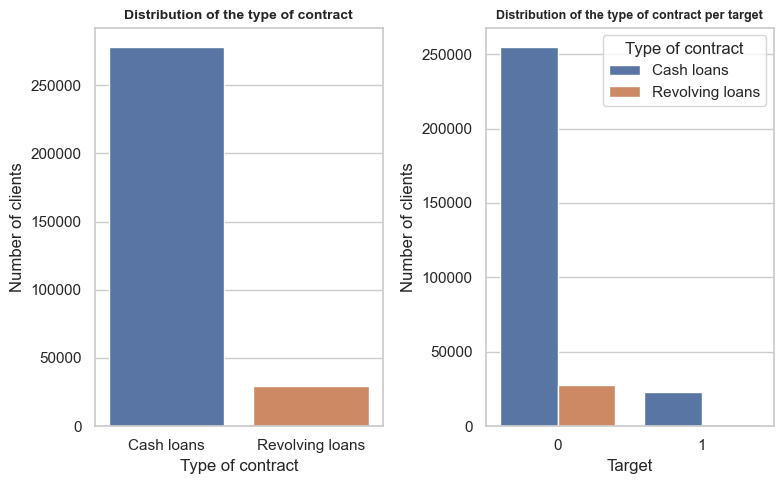

In [28]:
# NAME_CONTRACT_TYPE : Identification if loan is cash or revolving
display(train["NAME_CONTRACT_TYPE"].value_counts())

# NAME_CONTRACT_TYPE visualization
fig, axes = plt.subplots(1,2, figsize=(8,5))
# Distribution of the type of contracts
sns.countplot(data=train,x=train["NAME_CONTRACT_TYPE"],ax=axes[0])
axes[0].set_title("Distribution of the type of contract",fontweight="bold",fontsize=10)
axes[0].set_xlabel("Type of contract")
axes[0].set_ylabel("Number of clients")

# Distribution of the type of contracts per target
sns.countplot(data=train, x=train['TARGET'],hue=train['NAME_CONTRACT_TYPE'],ax=axes[1])
axes[1].set_title("Distribution of the type of contract per target",fontweight="bold",fontsize=9)
axes[1].set_xlabel("Target")
axes[1].set_ylabel("Number of clients")
axes[1].legend(bbox_to_anchor=(1,1),title="Type of contract")

plt.tight_layout()
plt.show()

* Cette colonne présente le type de contrat de prêts. L'écrasante majorité des emprunteurs ont un contrat de prêt en espèces.

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

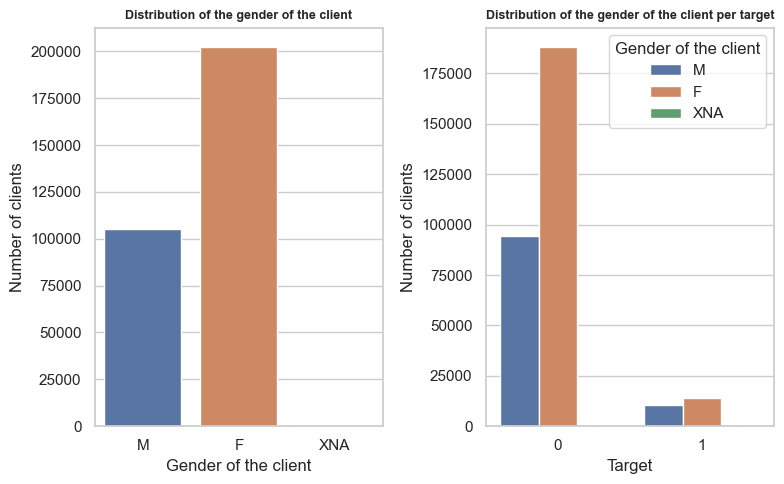

In [29]:
# CODE_GENDER : Gender of the client
display(train["CODE_GENDER"].value_counts())

# CODE_GENDER visualization
fig, axes = plt.subplots(1,2, figsize=(8,5))
# Distribution of the gender of the client
sns.countplot(data=train,x=train["CODE_GENDER"],ax=axes[0])
axes[0].set_title("Distribution of the gender of the client",fontweight="bold",fontsize=9)
axes[0].set_xlabel("Gender of the client")
axes[0].set_ylabel("Number of clients")

# Distribution of the gender of the client per target
sns.countplot(data=train, x=train["TARGET"],hue=train["CODE_GENDER"],ax=axes[1])
axes[1].set_title("Distribution of the gender of the client per target",fontweight="bold",fontsize=9)
axes[1].set_xlabel("Target")
axes[1].set_ylabel("Number of clients")
axes[1].legend(title="Gender of the client")

plt.tight_layout()
plt.show()

* On constate une plus forte présence des femmes parmi les emprunteurs.

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64

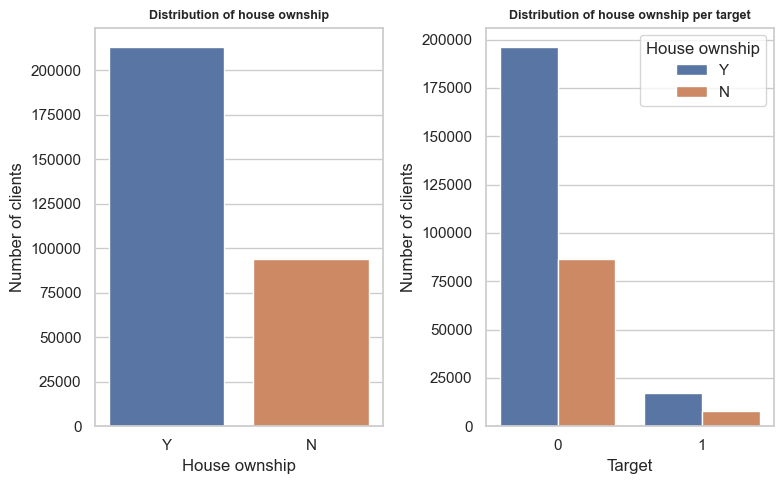

In [30]:
# FLAG_OWN_REALTY : Flag if client owns a house or flat
display(train["FLAG_OWN_REALTY"].value_counts())

# FLAG_OWN_REALTY visualization
fig, axes = plt.subplots(1,2, figsize=(8,5))
# Distribution of the client house ownship
sns.countplot(data=train,x=train["FLAG_OWN_REALTY"],ax=axes[0])
axes[0].set_title("Distribution of house ownship",fontweight="bold",fontsize=9)
axes[0].set_xlabel("House ownship")
axes[0].set_ylabel("Number of clients")

# Distribution of the client's house ownship per target
sns.countplot(data=train, x=train["TARGET"],hue=train["FLAG_OWN_REALTY"],ax=axes[1])
axes[1].set_title("Distribution of house ownship per target",fontweight="bold",fontsize=9)
axes[1].set_xlabel("Target")
axes[1].set_ylabel("Number of clients")
axes[1].legend(title="House ownship")

plt.tight_layout()
plt.show()

* La majorité des emprunteurs possèdent une maison ou un appartement.

## Analyse des variables numériques

In [31]:
train.select_dtypes(np.number).columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG',
       'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE',
       'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
      

In [32]:
train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [33]:
# A function to visualize the distribution of numerical features
def univariate_analysis(data,list_of_cols):
    
    for column in list_of_cols:
    
        if data[column].nunique() > 10:
            try:
                print(f"""Description et analyse univariée de la variable {column} :\n 
                 mean : {round(data[column].mean(),3)}\n
                 std : {round(data[column].std(),3)}\n
                 median : {round(data[column].median(),3)}\n
                 min : {round(data[column].min(),3)}\n
                 max : {round(data[column].max(),3)}
                    """)

                # Boxplot
                plt.figure(figsize=(5,5))
                sns.boxplot(x=column, data = data)
                plt.title(f"Distribution de la variable {column}")
                plt.show()   
                    
                 
            except :
                continue
              
        else :
            print(f"""Description et analyse univariée de la variable {column} :\n 
                 mean : {round(data[column].mean(),3)}\n
                 std : {round(data[column].std(),3)}\n
                 median : {round(data[column].median(),3)}\n
                 min : {round(data[column].min(),3)}\n
                 max : {round(data[column].max(),3)}
                    """)
            plt.figure(figsize=(5,5))
            data[column].plot.hist(title = f'{column} Histogram');
            plt.xlabel(f'{column}')
            plt.show()
            
        
        print()
        print("-"*70)
        print()

Description et analyse univariée de la variable SK_ID_CURR :
 
                 mean : 278180.519

                 std : 102790.175

                 median : 278202.0

                 min : 100002

                 max : 456255
                    


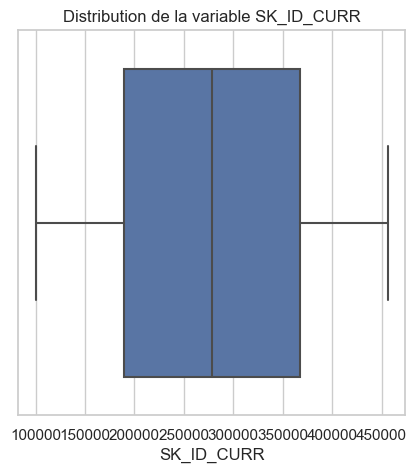


----------------------------------------------------------------------

Description et analyse univariée de la variable TARGET :
 
                 mean : 0.081

                 std : 0.272

                 median : 0.0

                 min : 0

                 max : 1
                    


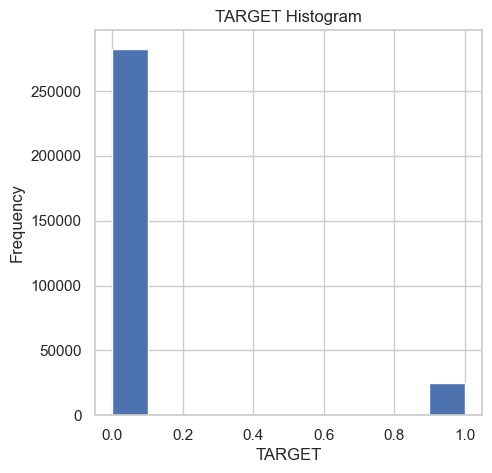


----------------------------------------------------------------------

Description et analyse univariée de la variable CNT_CHILDREN :
 
                 mean : 0.417

                 std : 0.722

                 median : 0.0

                 min : 0

                 max : 19
                    


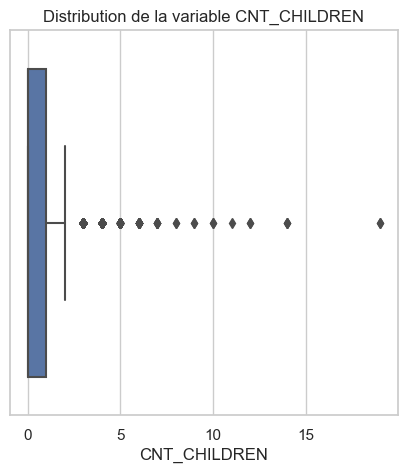


----------------------------------------------------------------------

Description et analyse univariée de la variable AMT_INCOME_TOTAL :
 
                 mean : 168797.919

                 std : 237123.146

                 median : 147150.0

                 min : 25650.0

                 max : 117000000.0
                    


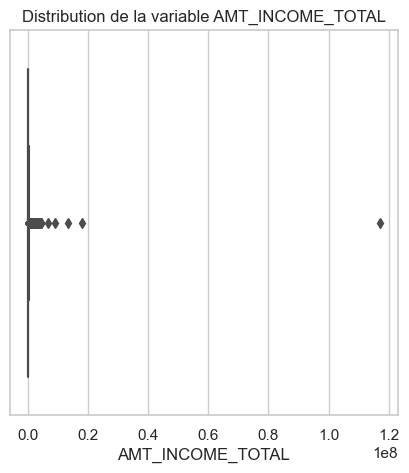


----------------------------------------------------------------------

Description et analyse univariée de la variable AMT_CREDIT :
 
                 mean : 599026.0

                 std : 402490.777

                 median : 513531.0

                 min : 45000.0

                 max : 4050000.0
                    


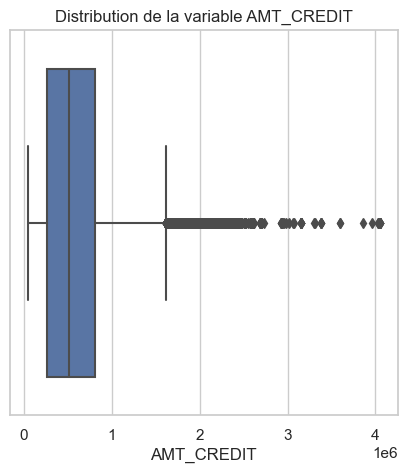


----------------------------------------------------------------------

Description et analyse univariée de la variable AMT_ANNUITY :
 
                 mean : 27108.574

                 std : 14493.737

                 median : 24903.0

                 min : 1615.5

                 max : 258025.5
                    


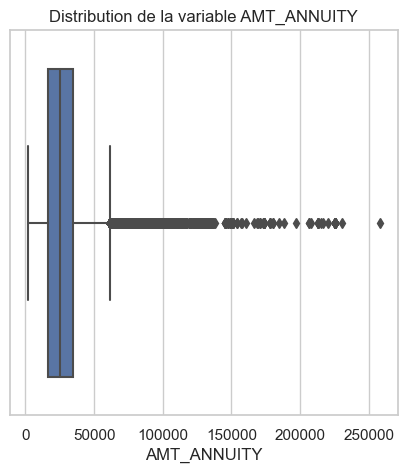


----------------------------------------------------------------------

Description et analyse univariée de la variable AMT_GOODS_PRICE :
 
                 mean : 538396.207

                 std : 369446.461

                 median : 450000.0

                 min : 40500.0

                 max : 4050000.0
                    


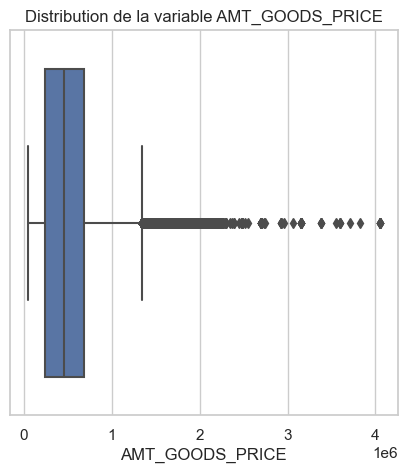


----------------------------------------------------------------------

Description et analyse univariée de la variable REGION_POPULATION_RELATIVE :
 
                 mean : 0.021

                 std : 0.014

                 median : 0.019

                 min : 0.0

                 max : 0.073
                    


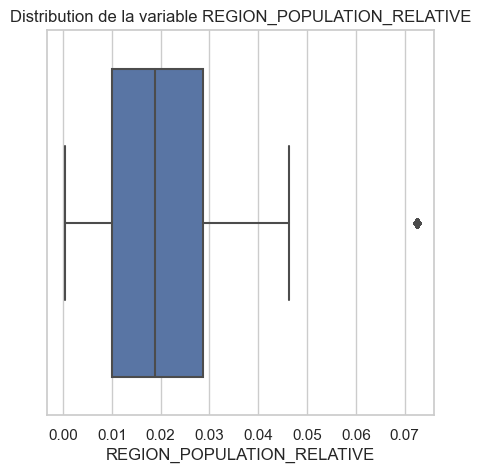


----------------------------------------------------------------------

Description et analyse univariée de la variable DAYS_BIRTH :
 
                 mean : -16036.995

                 std : 4363.989

                 median : -15750.0

                 min : -25229

                 max : -7489
                    


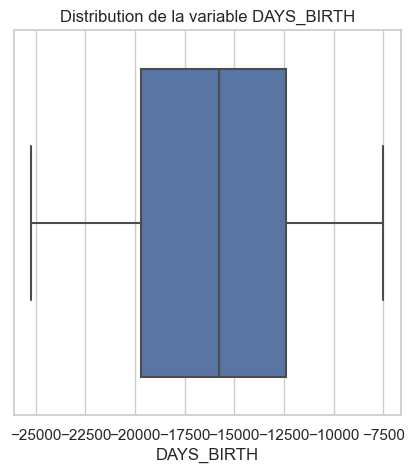


----------------------------------------------------------------------

Description et analyse univariée de la variable DAYS_EMPLOYED :
 
                 mean : 63815.046

                 std : 141275.767

                 median : -1213.0

                 min : -17912

                 max : 365243
                    


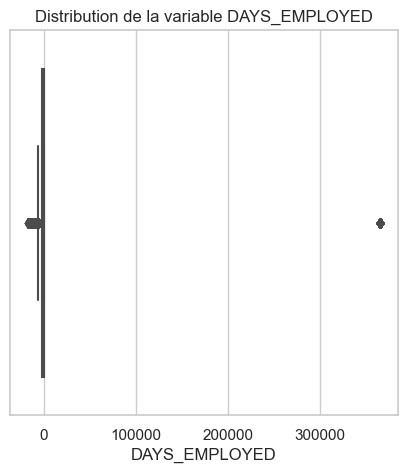


----------------------------------------------------------------------

Description et analyse univariée de la variable DAYS_REGISTRATION :
 
                 mean : -4986.12

                 std : 3522.886

                 median : -4504.0

                 min : -24672.0

                 max : 0.0
                    


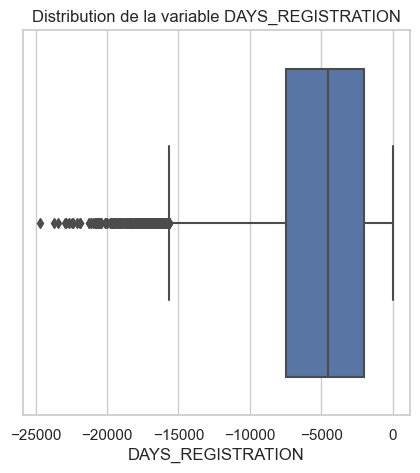


----------------------------------------------------------------------

Description et analyse univariée de la variable DAYS_ID_PUBLISH :
 
                 mean : -2994.202

                 std : 1509.45

                 median : -3254.0

                 min : -7197

                 max : 0
                    


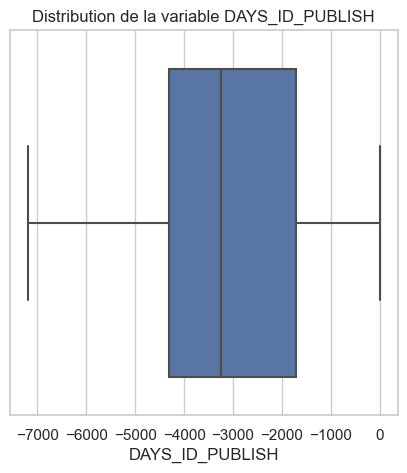


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_MOBIL :
 
                 mean : 1.0

                 std : 0.002

                 median : 1.0

                 min : 0

                 max : 1
                    


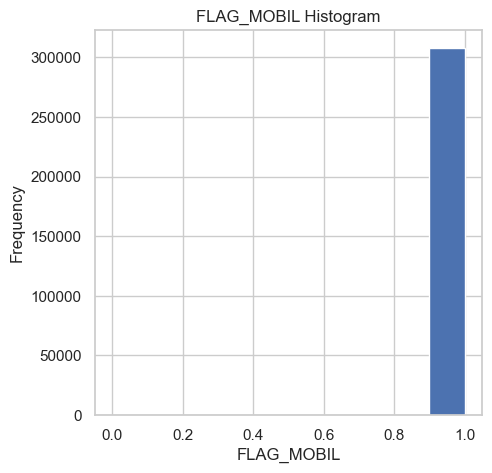


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_EMP_PHONE :
 
                 mean : 0.82

                 std : 0.384

                 median : 1.0

                 min : 0

                 max : 1
                    


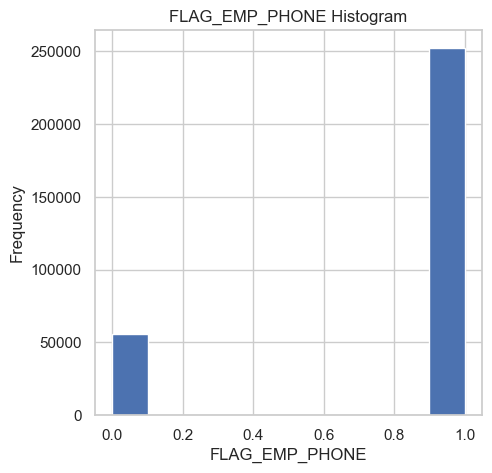


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_WORK_PHONE :
 
                 mean : 0.199

                 std : 0.4

                 median : 0.0

                 min : 0

                 max : 1
                    


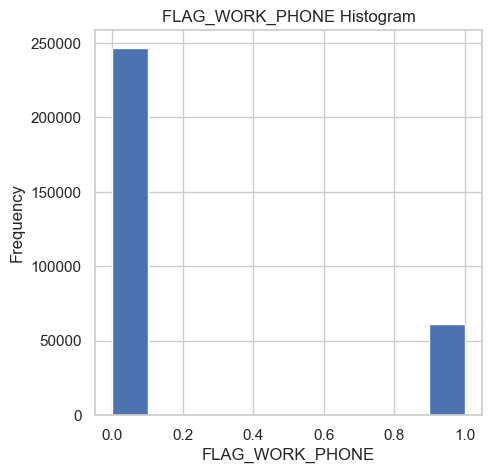


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_CONT_MOBILE :
 
                 mean : 0.998

                 std : 0.043

                 median : 1.0

                 min : 0

                 max : 1
                    


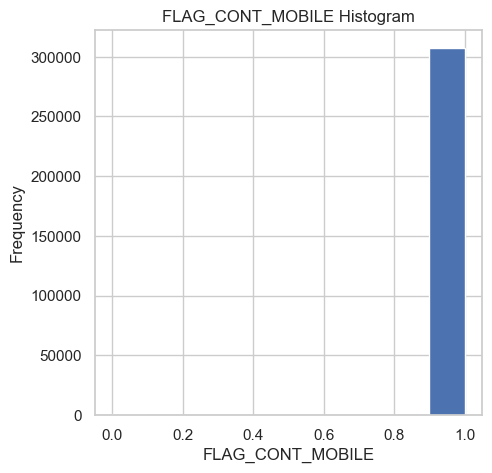


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_PHONE :
 
                 mean : 0.281

                 std : 0.45

                 median : 0.0

                 min : 0

                 max : 1
                    


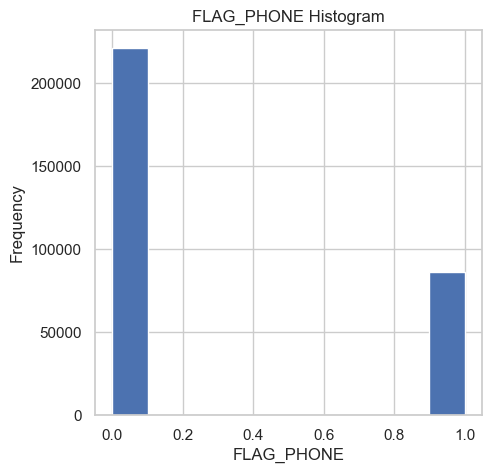


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_EMAIL :
 
                 mean : 0.057

                 std : 0.231

                 median : 0.0

                 min : 0

                 max : 1
                    


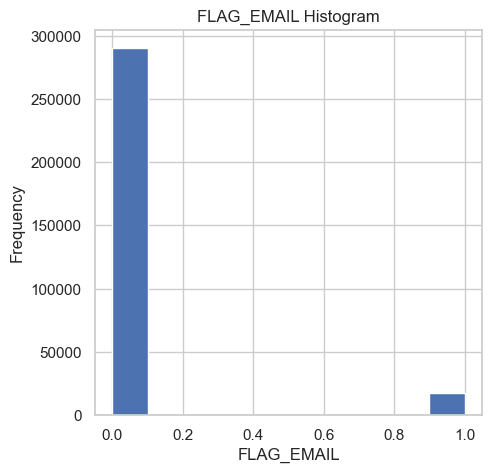


----------------------------------------------------------------------

Description et analyse univariée de la variable CNT_FAM_MEMBERS :
 
                 mean : 2.153

                 std : 0.911

                 median : 2.0

                 min : 1.0

                 max : 20.0
                    


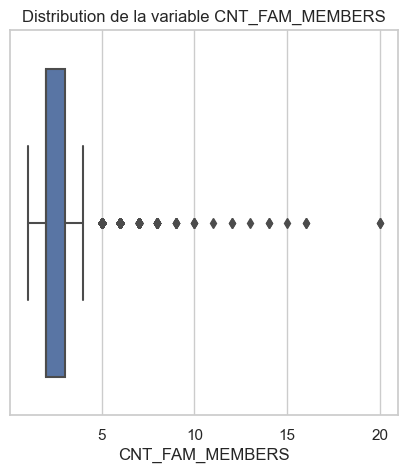


----------------------------------------------------------------------

Description et analyse univariée de la variable REGION_RATING_CLIENT :
 
                 mean : 2.052

                 std : 0.509

                 median : 2.0

                 min : 1

                 max : 3
                    


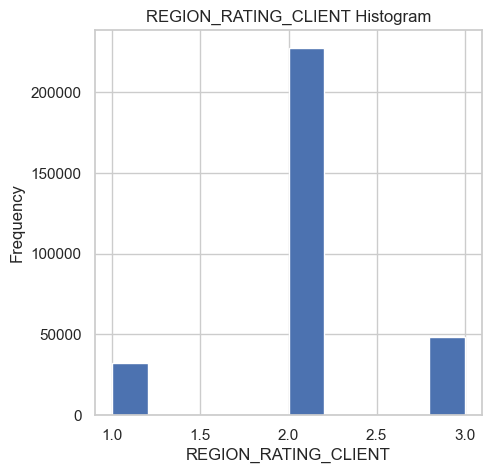


----------------------------------------------------------------------

Description et analyse univariée de la variable REGION_RATING_CLIENT_W_CITY :
 
                 mean : 2.032

                 std : 0.503

                 median : 2.0

                 min : 1

                 max : 3
                    


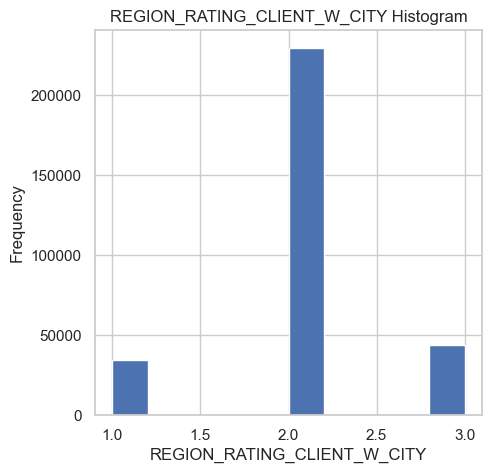


----------------------------------------------------------------------

Description et analyse univariée de la variable HOUR_APPR_PROCESS_START :
 
                 mean : 12.063

                 std : 3.266

                 median : 12.0

                 min : 0

                 max : 23
                    


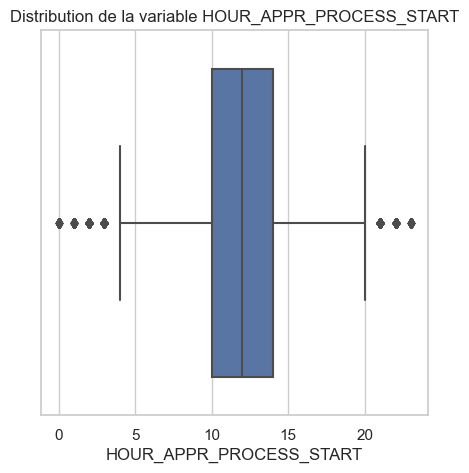


----------------------------------------------------------------------

Description et analyse univariée de la variable REG_REGION_NOT_LIVE_REGION :
 
                 mean : 0.015

                 std : 0.122

                 median : 0.0

                 min : 0

                 max : 1
                    


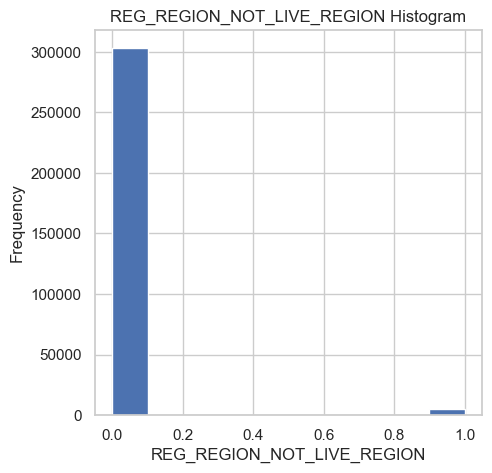


----------------------------------------------------------------------

Description et analyse univariée de la variable REG_REGION_NOT_WORK_REGION :
 
                 mean : 0.051

                 std : 0.22

                 median : 0.0

                 min : 0

                 max : 1
                    


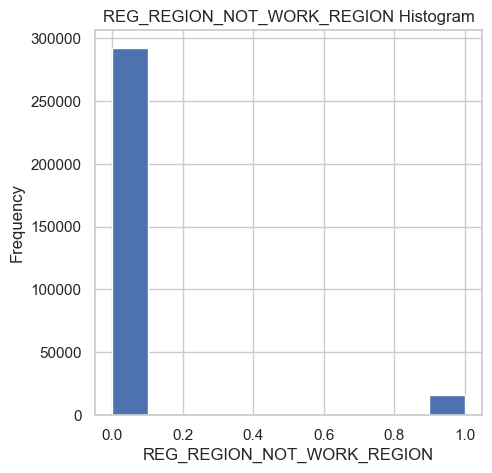


----------------------------------------------------------------------

Description et analyse univariée de la variable LIVE_REGION_NOT_WORK_REGION :
 
                 mean : 0.041

                 std : 0.197

                 median : 0.0

                 min : 0

                 max : 1
                    


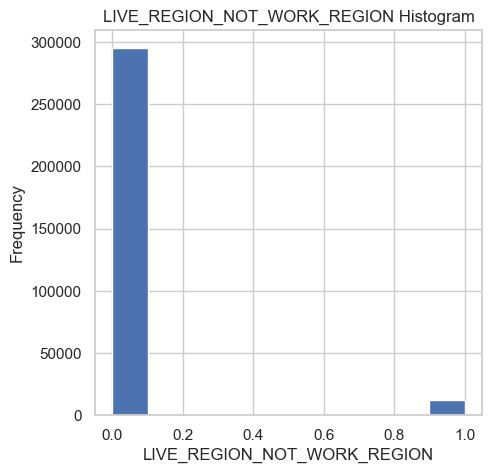


----------------------------------------------------------------------

Description et analyse univariée de la variable REG_CITY_NOT_LIVE_CITY :
 
                 mean : 0.078

                 std : 0.268

                 median : 0.0

                 min : 0

                 max : 1
                    


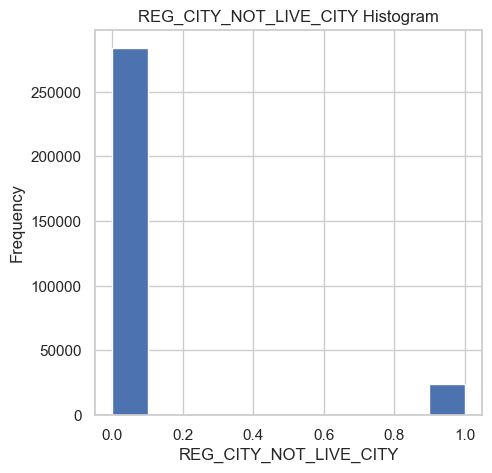


----------------------------------------------------------------------

Description et analyse univariée de la variable REG_CITY_NOT_WORK_CITY :
 
                 mean : 0.23

                 std : 0.421

                 median : 0.0

                 min : 0

                 max : 1
                    


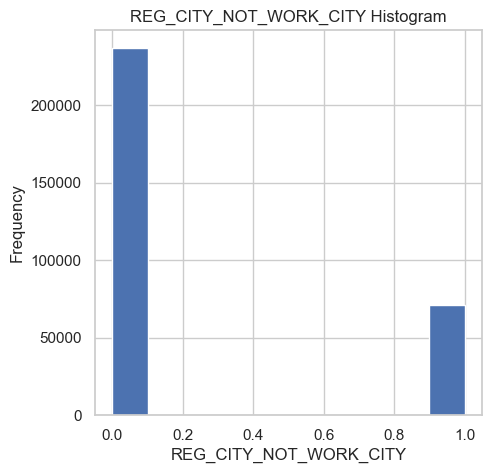


----------------------------------------------------------------------

Description et analyse univariée de la variable LIVE_CITY_NOT_WORK_CITY :
 
                 mean : 0.18

                 std : 0.384

                 median : 0.0

                 min : 0

                 max : 1
                    


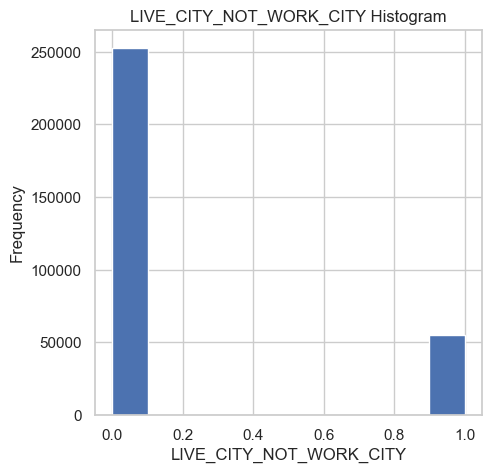


----------------------------------------------------------------------

Description et analyse univariée de la variable EXT_SOURCE_2 :
 
                 mean : 0.514

                 std : 0.191

                 median : 0.566

                 min : 0.0

                 max : 0.855
                    


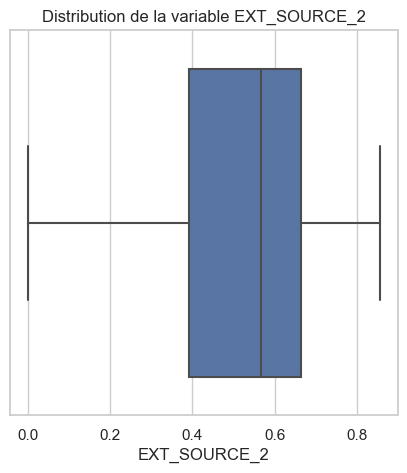


----------------------------------------------------------------------

Description et analyse univariée de la variable EXT_SOURCE_3 :
 
                 mean : 0.511

                 std : 0.195

                 median : 0.535

                 min : 0.001

                 max : 0.896
                    


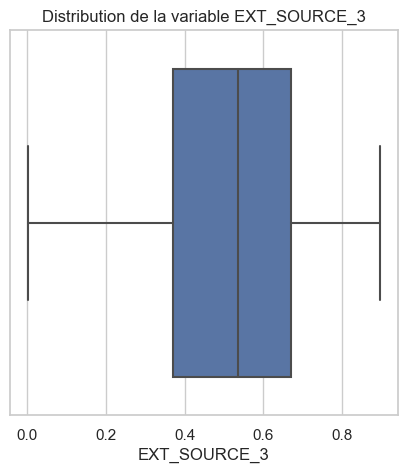


----------------------------------------------------------------------

Description et analyse univariée de la variable YEARS_BEGINEXPLUATATION_AVG :
 
                 mean : 0.978

                 std : 0.059

                 median : 0.982

                 min : 0.0

                 max : 1.0
                    


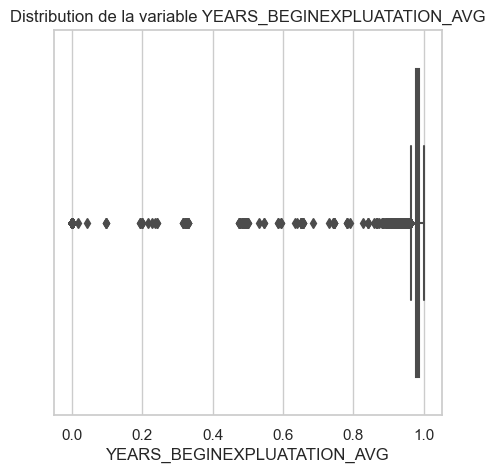


----------------------------------------------------------------------

Description et analyse univariée de la variable FLOORSMAX_AVG :
 
                 mean : 0.226

                 std : 0.145

                 median : 0.167

                 min : 0.0

                 max : 1.0
                    


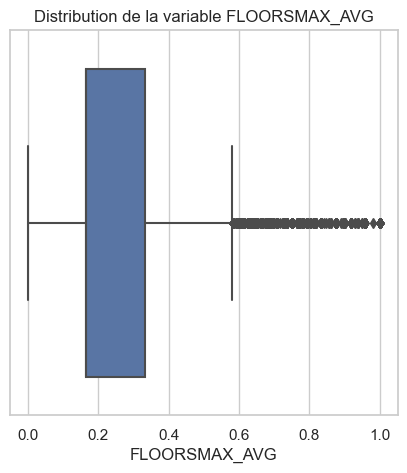


----------------------------------------------------------------------

Description et analyse univariée de la variable YEARS_BEGINEXPLUATATION_MODE :
 
                 mean : 0.977

                 std : 0.065

                 median : 0.982

                 min : 0.0

                 max : 1.0
                    


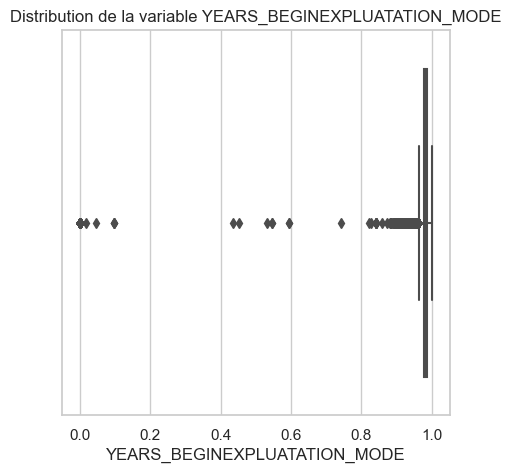


----------------------------------------------------------------------

Description et analyse univariée de la variable FLOORSMAX_MODE :
 
                 mean : 0.222

                 std : 0.144

                 median : 0.167

                 min : 0.0

                 max : 1.0
                    


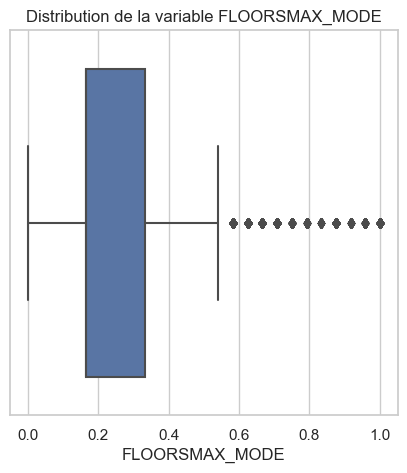


----------------------------------------------------------------------

Description et analyse univariée de la variable YEARS_BEGINEXPLUATATION_MEDI :
 
                 mean : 0.978

                 std : 0.06

                 median : 0.982

                 min : 0.0

                 max : 1.0
                    


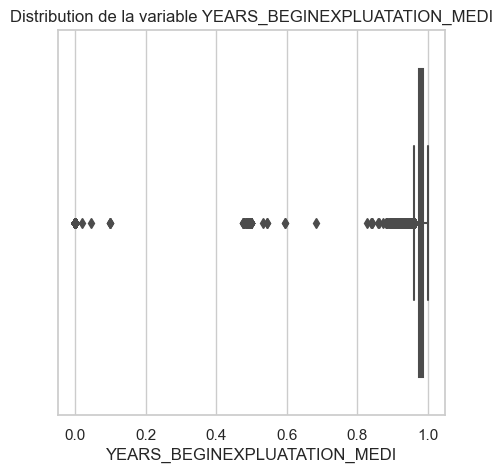


----------------------------------------------------------------------

Description et analyse univariée de la variable FLOORSMAX_MEDI :
 
                 mean : 0.226

                 std : 0.145

                 median : 0.167

                 min : 0.0

                 max : 1.0
                    


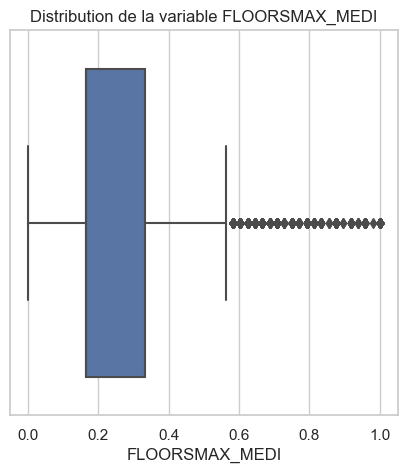


----------------------------------------------------------------------

Description et analyse univariée de la variable TOTALAREA_MODE :
 
                 mean : 0.103

                 std : 0.107

                 median : 0.069

                 min : 0.0

                 max : 1.0
                    


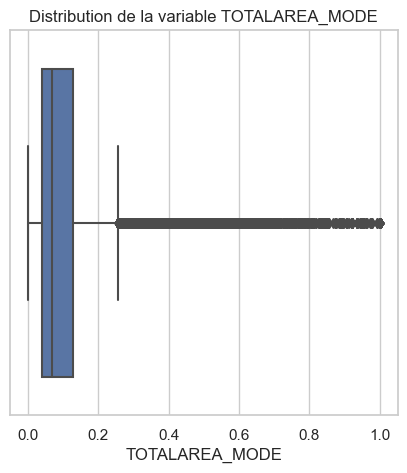


----------------------------------------------------------------------

Description et analyse univariée de la variable OBS_30_CNT_SOCIAL_CIRCLE :
 
                 mean : 1.422

                 std : 2.401

                 median : 0.0

                 min : 0.0

                 max : 348.0
                    


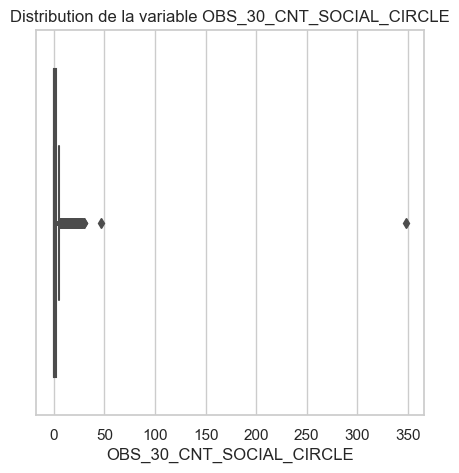


----------------------------------------------------------------------

Description et analyse univariée de la variable DEF_30_CNT_SOCIAL_CIRCLE :
 
                 mean : 0.143

                 std : 0.447

                 median : 0.0

                 min : 0.0

                 max : 34.0
                    


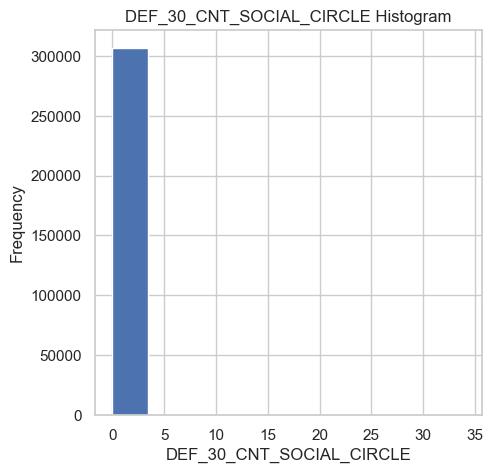


----------------------------------------------------------------------

Description et analyse univariée de la variable OBS_60_CNT_SOCIAL_CIRCLE :
 
                 mean : 1.405

                 std : 2.38

                 median : 0.0

                 min : 0.0

                 max : 344.0
                    


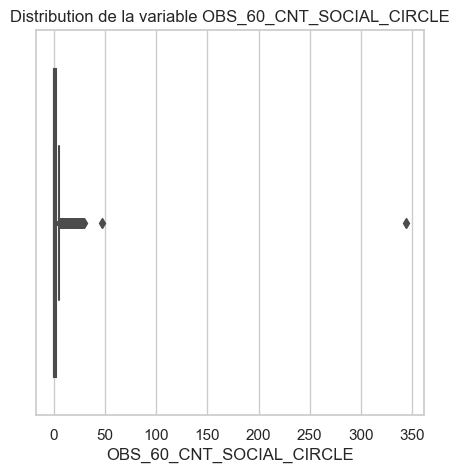


----------------------------------------------------------------------

Description et analyse univariée de la variable DEF_60_CNT_SOCIAL_CIRCLE :
 
                 mean : 0.1

                 std : 0.362

                 median : 0.0

                 min : 0.0

                 max : 24.0
                    


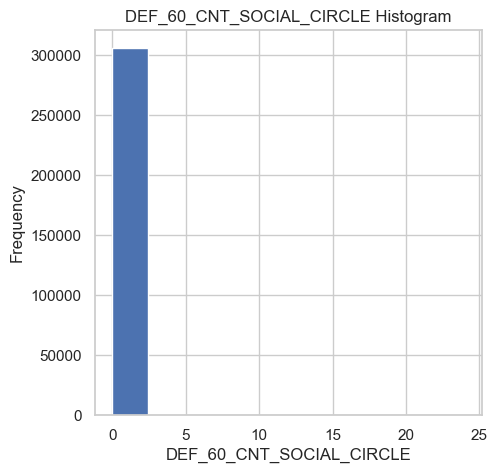


----------------------------------------------------------------------

Description et analyse univariée de la variable DAYS_LAST_PHONE_CHANGE :
 
                 mean : -962.859

                 std : 826.808

                 median : -757.0

                 min : -4292.0

                 max : 0.0
                    


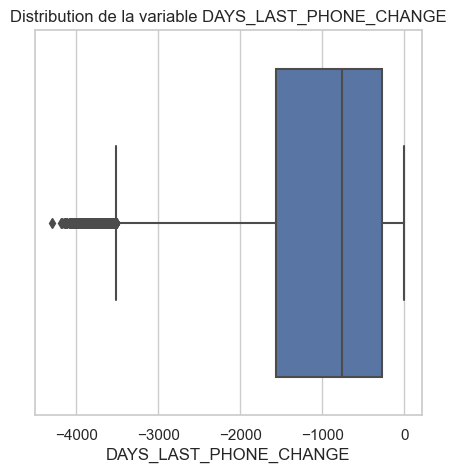


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_2 :
 
                 mean : 0.0

                 std : 0.007

                 median : 0.0

                 min : 0

                 max : 1
                    


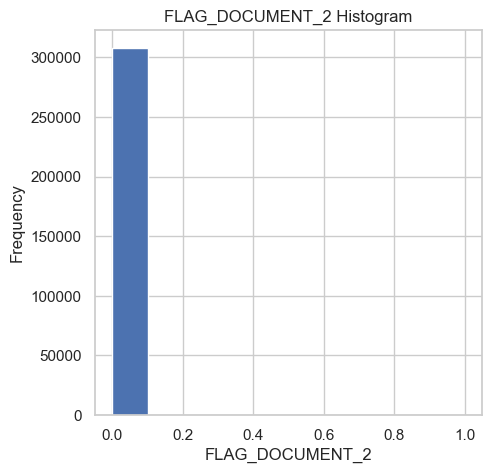


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_3 :
 
                 mean : 0.71

                 std : 0.454

                 median : 1.0

                 min : 0

                 max : 1
                    


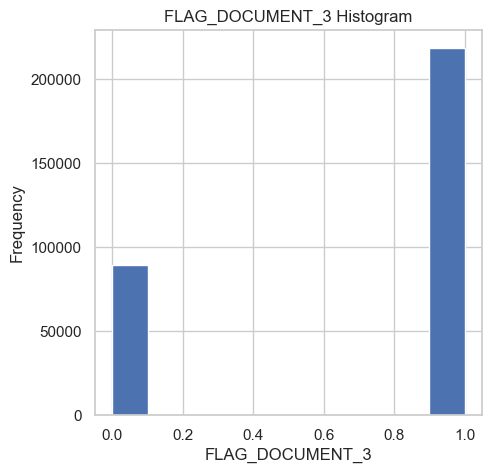


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_4 :
 
                 mean : 0.0

                 std : 0.009

                 median : 0.0

                 min : 0

                 max : 1
                    


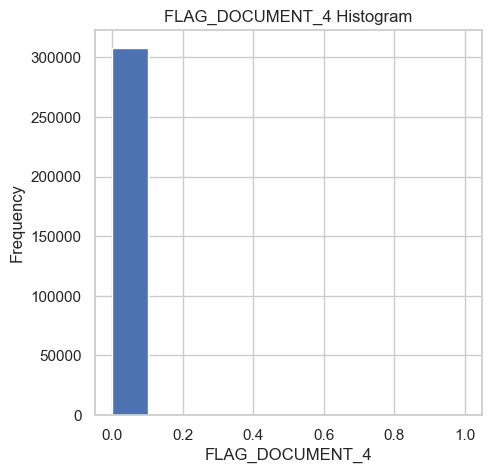


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_5 :
 
                 mean : 0.015

                 std : 0.122

                 median : 0.0

                 min : 0

                 max : 1
                    


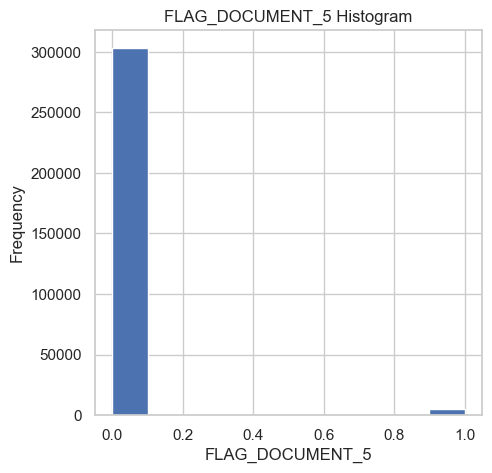


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_6 :
 
                 mean : 0.088

                 std : 0.283

                 median : 0.0

                 min : 0

                 max : 1
                    


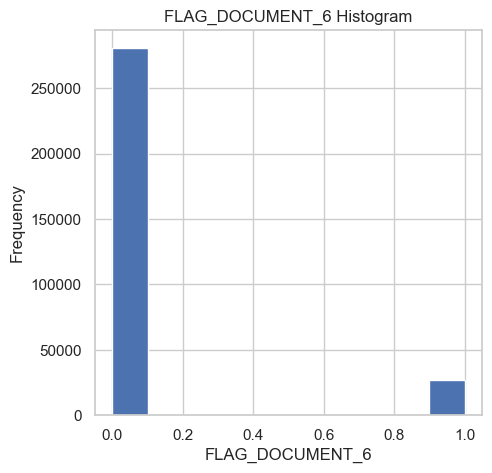


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_7 :
 
                 mean : 0.0

                 std : 0.014

                 median : 0.0

                 min : 0

                 max : 1
                    


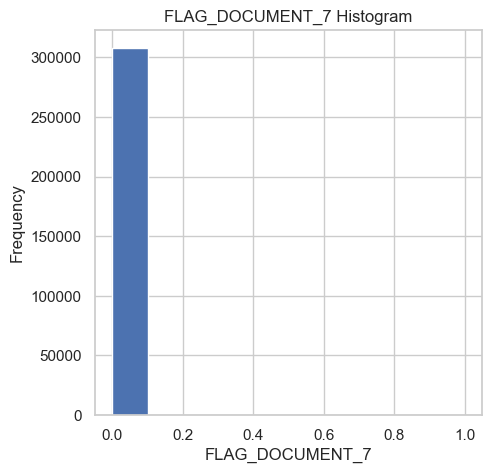


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_8 :
 
                 mean : 0.081

                 std : 0.273

                 median : 0.0

                 min : 0

                 max : 1
                    


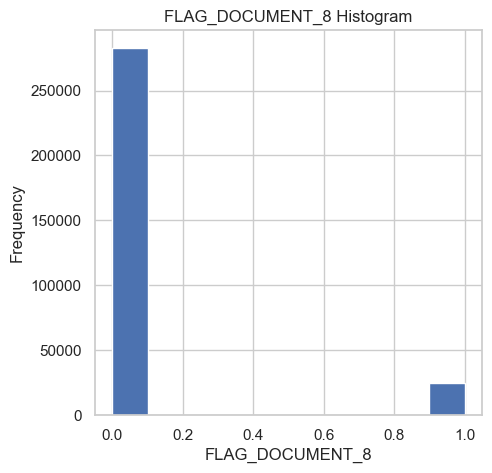


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_9 :
 
                 mean : 0.004

                 std : 0.062

                 median : 0.0

                 min : 0

                 max : 1
                    


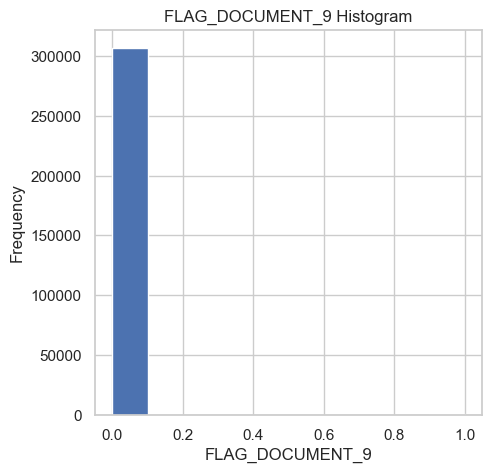


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_10 :
 
                 mean : 0.0

                 std : 0.005

                 median : 0.0

                 min : 0

                 max : 1
                    


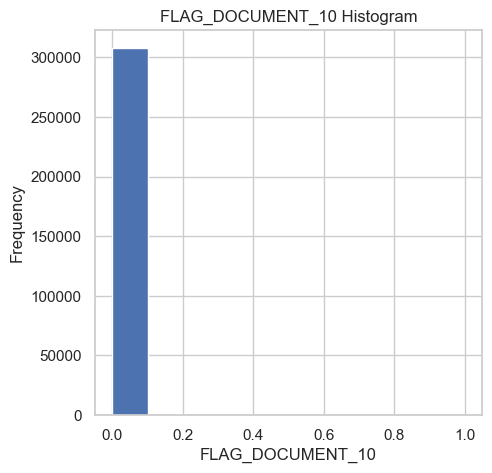


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_11 :
 
                 mean : 0.004

                 std : 0.062

                 median : 0.0

                 min : 0

                 max : 1
                    


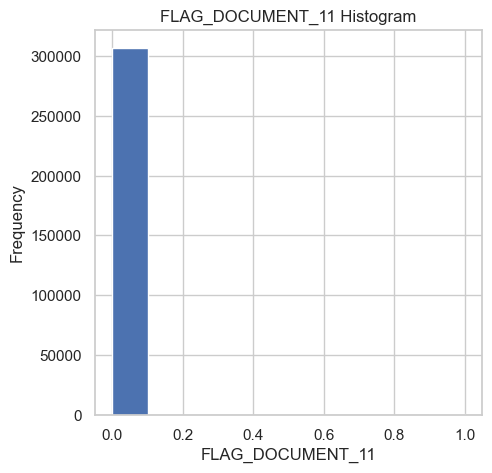


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_12 :
 
                 mean : 0.0

                 std : 0.003

                 median : 0.0

                 min : 0

                 max : 1
                    


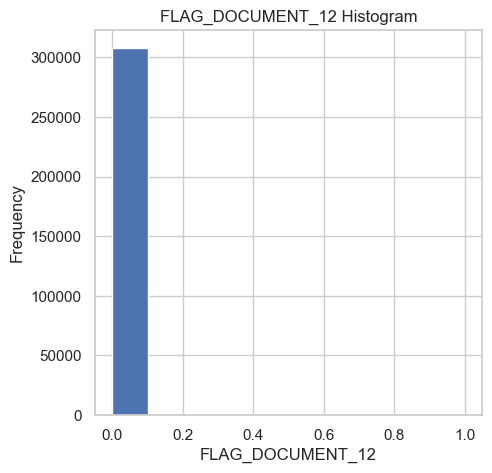


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_13 :
 
                 mean : 0.004

                 std : 0.059

                 median : 0.0

                 min : 0

                 max : 1
                    


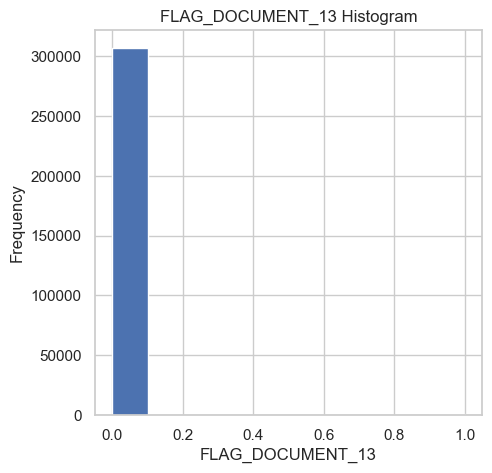


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_14 :
 
                 mean : 0.003

                 std : 0.054

                 median : 0.0

                 min : 0

                 max : 1
                    


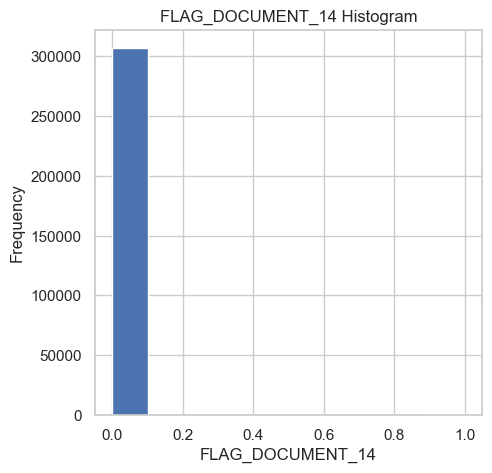


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_15 :
 
                 mean : 0.001

                 std : 0.035

                 median : 0.0

                 min : 0

                 max : 1
                    


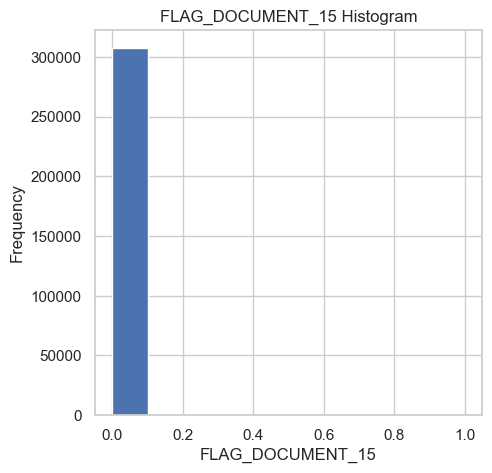


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_16 :
 
                 mean : 0.01

                 std : 0.099

                 median : 0.0

                 min : 0

                 max : 1
                    


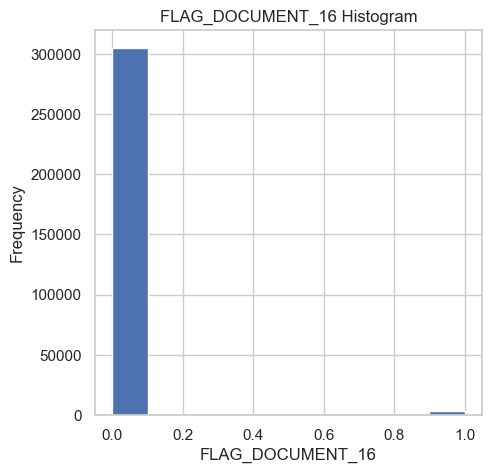


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_17 :
 
                 mean : 0.0

                 std : 0.016

                 median : 0.0

                 min : 0

                 max : 1
                    


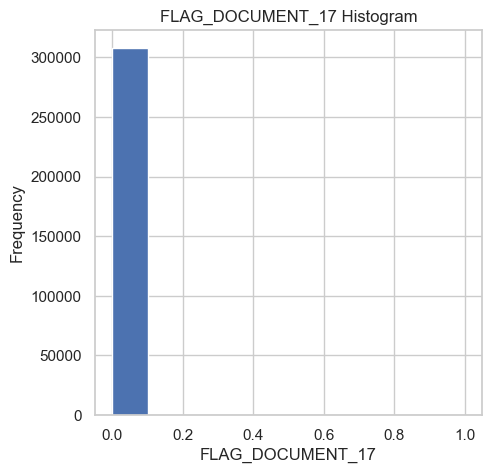


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_18 :
 
                 mean : 0.008

                 std : 0.09

                 median : 0.0

                 min : 0

                 max : 1
                    


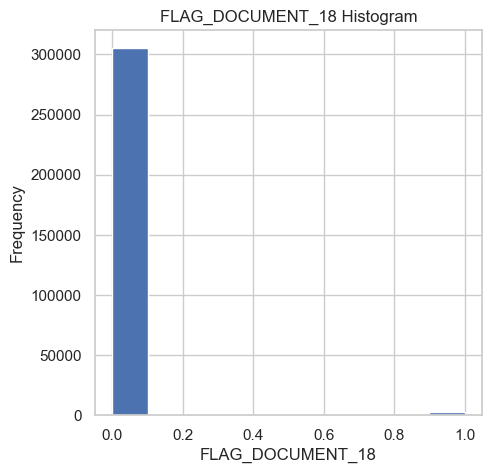


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_19 :
 
                 mean : 0.001

                 std : 0.024

                 median : 0.0

                 min : 0

                 max : 1
                    


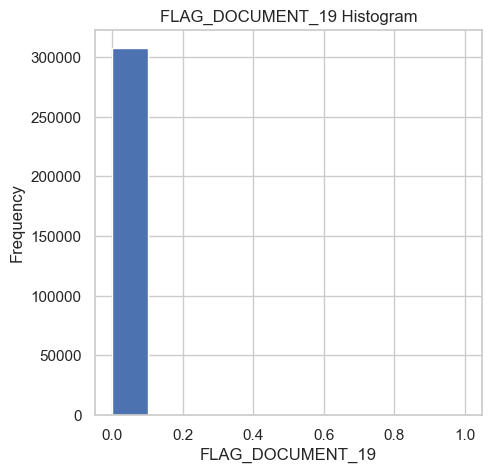


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_20 :
 
                 mean : 0.001

                 std : 0.023

                 median : 0.0

                 min : 0

                 max : 1
                    


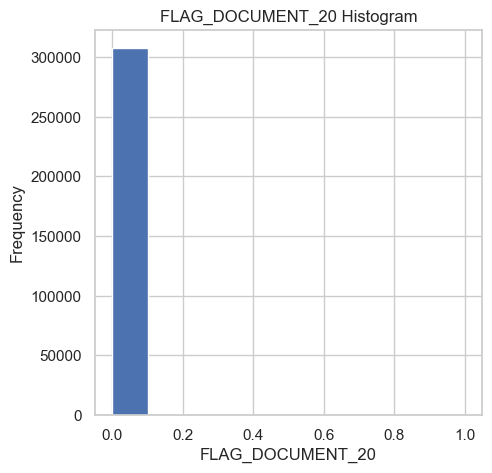


----------------------------------------------------------------------

Description et analyse univariée de la variable FLAG_DOCUMENT_21 :
 
                 mean : 0.0

                 std : 0.018

                 median : 0.0

                 min : 0

                 max : 1
                    


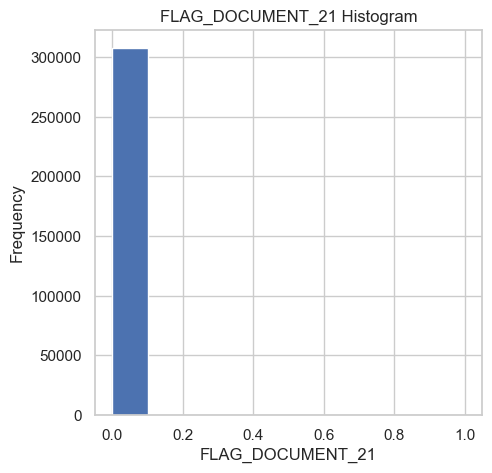


----------------------------------------------------------------------

Description et analyse univariée de la variable AMT_REQ_CREDIT_BUREAU_HOUR :
 
                 mean : 0.006

                 std : 0.084

                 median : 0.0

                 min : 0.0

                 max : 4.0
                    


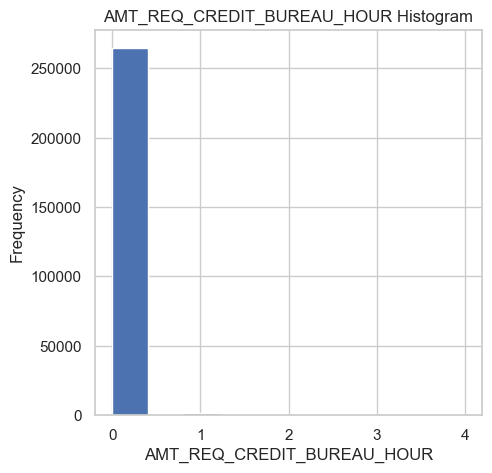


----------------------------------------------------------------------

Description et analyse univariée de la variable AMT_REQ_CREDIT_BUREAU_DAY :
 
                 mean : 0.007

                 std : 0.111

                 median : 0.0

                 min : 0.0

                 max : 9.0
                    


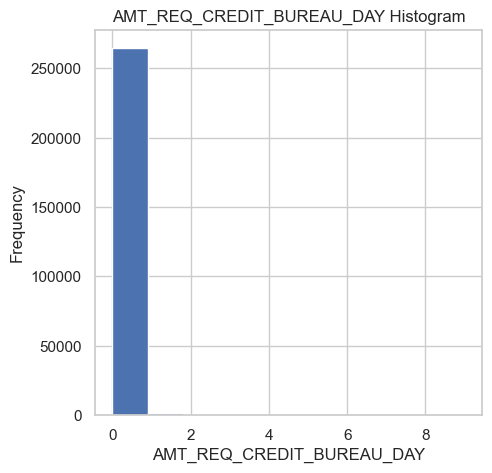


----------------------------------------------------------------------

Description et analyse univariée de la variable AMT_REQ_CREDIT_BUREAU_WEEK :
 
                 mean : 0.034

                 std : 0.205

                 median : 0.0

                 min : 0.0

                 max : 8.0
                    


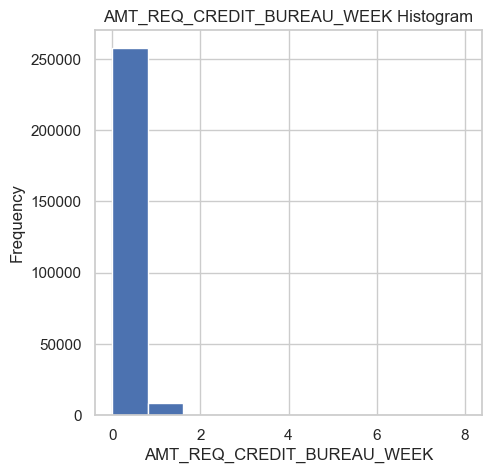


----------------------------------------------------------------------

Description et analyse univariée de la variable AMT_REQ_CREDIT_BUREAU_MON :
 
                 mean : 0.267

                 std : 0.916

                 median : 0.0

                 min : 0.0

                 max : 27.0
                    


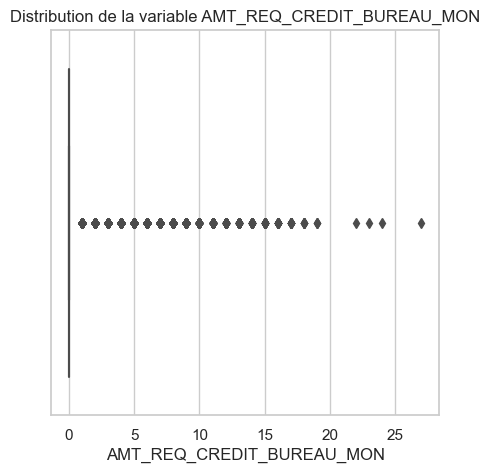


----------------------------------------------------------------------

Description et analyse univariée de la variable AMT_REQ_CREDIT_BUREAU_QRT :
 
                 mean : 0.265

                 std : 0.794

                 median : 0.0

                 min : 0.0

                 max : 261.0
                    


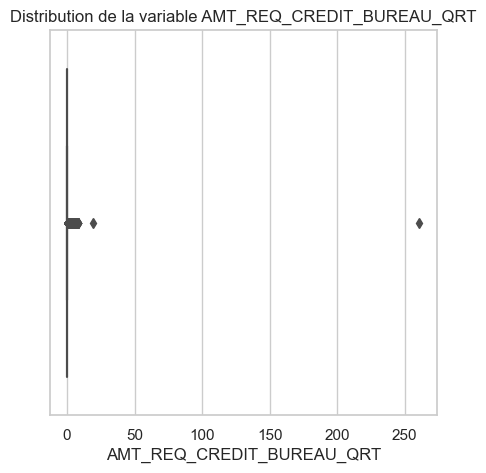


----------------------------------------------------------------------

Description et analyse univariée de la variable AMT_REQ_CREDIT_BUREAU_YEAR :
 
                 mean : 1.9

                 std : 1.869

                 median : 1.0

                 min : 0.0

                 max : 25.0
                    


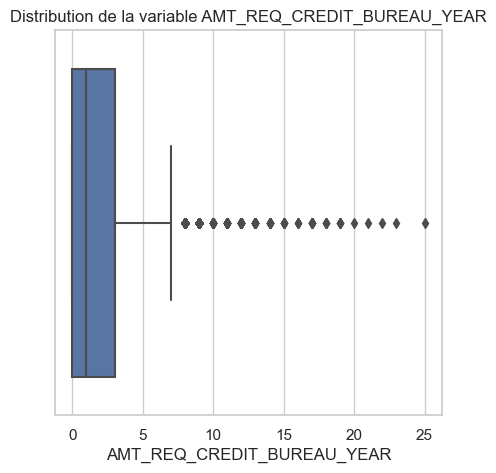


----------------------------------------------------------------------



In [34]:
# Apply univariate visulisation to all numeric columns
numeric_columns = train.select_dtypes(np.number).columns
univariate_analysis(train,numeric_columns)

* La plupart des variables numériques contiennent beaucoup de valeurs atypiques/aberrantes.
* Certaines variables dont les noms commencent par "FLAG" ne varient pas pour la plupart. Nous allons supprimer toutes ces variables qui sont en fait des constantes.
* Les variables commençant par "DAYS" contiennent des anomalies que l'on traitera également.

* Les valeurs de la colonne DAYS_BIRTH sont négatifs car elles sont enregistrées par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, nous pouvons multiplier par -1 et diviser par le nombre de jours dans une année comme suit :

In [35]:
# Client's age in years at the time of application
(train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

* Ces âges semblent raisonnables. Il n'y a pas de valeurs aberrantes pour l'âge. Regardons maintenant la variable DAYS_EMPLOYED.

In [36]:
# DAYS_EMPLOYED : How many days before the application the person started current employment
display("Description de la variable 'DAYS_EMPLOYED' :", train["DAYS_EMPLOYED"].describe())
print()
display("Le nombre de fois où la variable 'DAYS_EMPLOYED' prend une valeure positive :",
        train[train["DAYS_EMPLOYED"]>0].DAYS_EMPLOYED.shape[0])
print()
display("Les valeurs aberrantes sont :",train[train["DAYS_EMPLOYED"]>0].DAYS_EMPLOYED.unique().tolist())

"Description de la variable 'DAYS_EMPLOYED' :"

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

"Le nombre de fois où la variable 'DAYS_EMPLOYED' prend une valeure positive :"

55374

'Les valeurs aberrantes sont :'

[365243]

* Cela ne semble pas correct ! La valeur maximale (en plus d'être positive) est d'environ 1000 ans ! Nous remplaçons cette valeure comme une valeure manquante.

'Taille du jeu de données :'

(307511, 65)

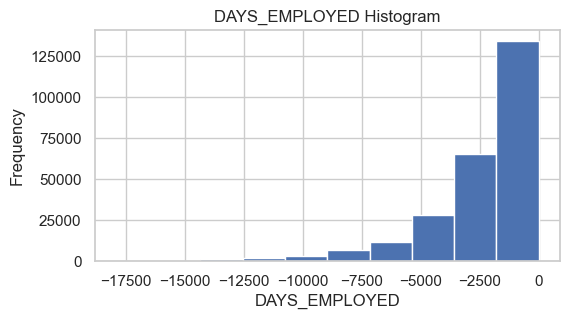

In [37]:
# Replace the anomalous values with nan
train["DAYS_EMPLOYED"] = train["DAYS_EMPLOYED"].replace({365243:np.nan})
test["DAYS_EMPLOYED"] = test["DAYS_EMPLOYED"].replace({365243:np.nan})

# Remove unvariated columns
train = train.drop(["FLAG_MOBIL","FLAG_CONT_MOBILE","FLAG_DOCUMENT_2","FLAG_DOCUMENT_4","FLAG_DOCUMENT_7",
                    "FLAG_DOCUMENT_10","FLAG_DOCUMENT_12","FLAG_DOCUMENT_14","FLAG_DOCUMENT_15","FLAG_DOCUMENT_17",
                   "FLAG_DOCUMENT_19","FLAG_DOCUMENT_20","FLAG_DOCUMENT_21"],axis=1)
display("Taille du jeu de données :",train.shape)
print()

plt.figure(figsize=(6,3))
train["DAYS_EMPLOYED"].plot.hist(title="DAYS_EMPLOYED Histogram")
plt.xlabel("DAYS_EMPLOYED")
plt.show()

In [38]:
# Number of each type of column
display(train.dtypes.value_counts())
display(test.dtypes.value_counts())

float64    28
int64      27
object     10
dtype: int64

int64      39
float64    38
object     15
dtype: int64

## Corrélations

* Une façon d'essayer de comprendre les données est de rechercher des corrélations entre les caractéristiques et la cible. Calculons le coefficient de corrélation de Pearson entre chaque variable et la cible.

In [39]:
# Find correlations with the target
correlations = train.corr(numeric_only=True)["TARGET"].sort_values(ascending=True)

# Display correlations
print("15 most positive correlations :\n", correlations.tail(15))
print()
print("\n15 most negative correlations :\n", correlations.head(15))

15 most positive correlations :
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64


15 most negative correlations :
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
TOTALAREA_MODE               -

* DAYS_BIRTH est la variable la plus corrélée positivement avec la colonne TARGET. Nous pouvons donc dire que plus le client vieillit, moins il est susceptible de faire défaut sur son prêt (TARGET==0).
* Représentons graphiquement cette évolution de la capacité à rembourser les prêts à temps en fonction du groupe d'âge :

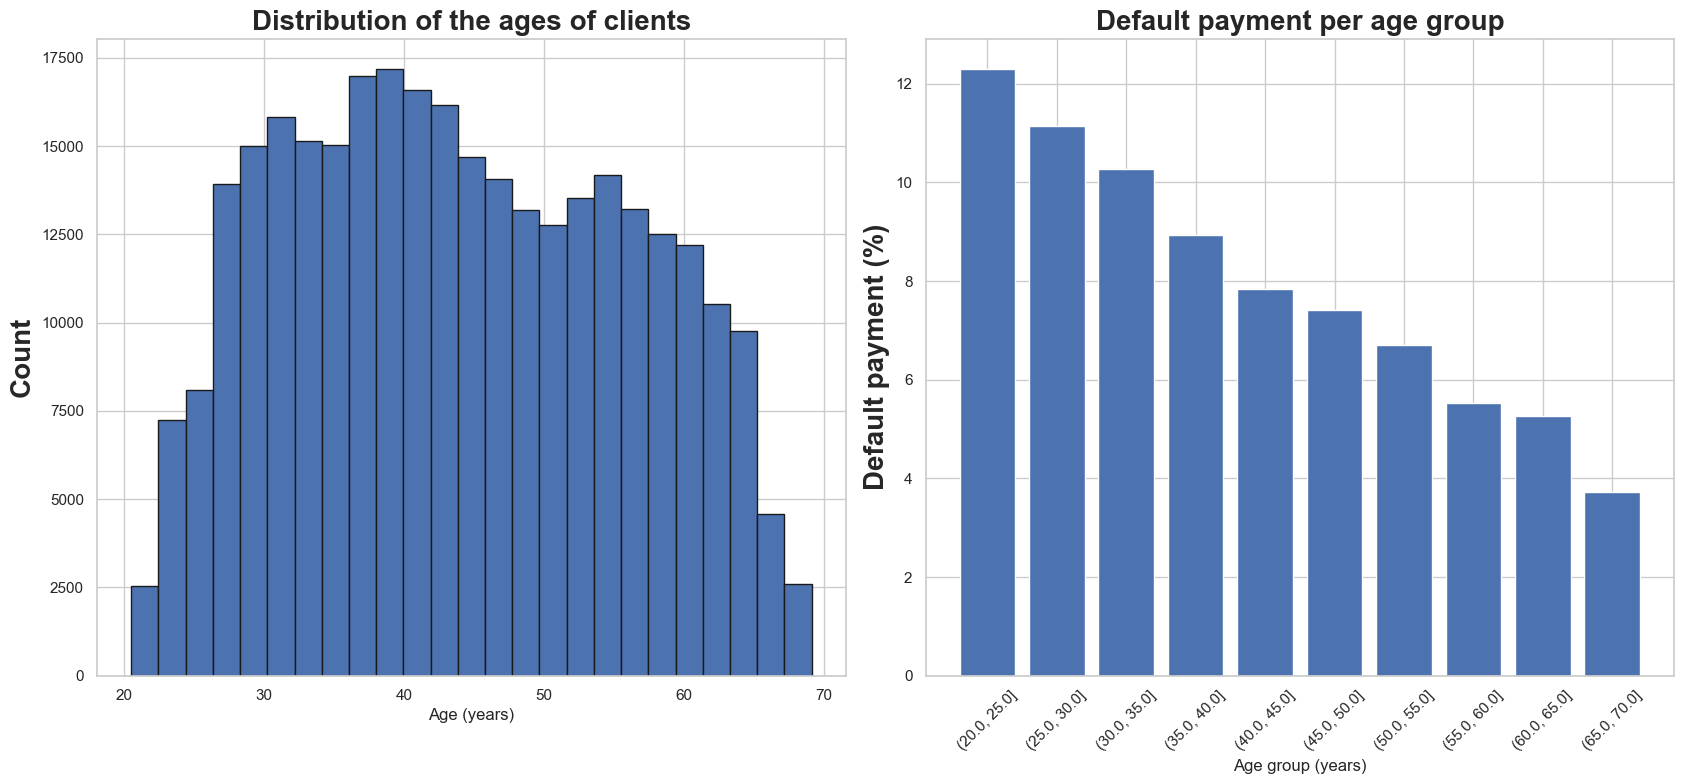

In [45]:
# Absolute values of the DAYS_BIRTH values
train["DAYS_BIRTH"] = abs(train["DAYS_BIRTH"])

# Age information into a separate dataframe
age_data = train[["TARGET","DAYS_BIRTH"]]
age_data["YEARS_BIRTH"] = age_data["DAYS_BIRTH"] / 365

# Bin the age data
age_data["YEARS_BINNED"] = pd.cut(age_data["YEARS_BIRTH"],bins=np.linspace(20,70,num=11))
# Group by the bin and calculate averages
age_groups  = age_data.groupby("YEARS_BINNED").mean()

fig, axes = plt.subplots(1,2, figsize=(17,8))
# Plot the distribution of ages in years
axes[0].hist(train["DAYS_BIRTH"] / 365,edgecolor="k",bins=25)
axes[0].set_title("Distribution of the ages of clients",fontweight="bold",fontsize=20)
axes[0].set_xlabel("Age (years)")
axes[0].set_ylabel("Count",fontweight="bold",fontsize=20)

# Plot the age bins and the average of the target as a bar plot
axes[1].bar(age_groups.index.astype(str),age_groups["TARGET"] * 100)
axes[1].set_title("Default payment per age group",fontweight="bold",fontsize=20)
axes[1].set_xlabel("Age group (years)")
axes[1].tick_params(axis="x",labelrotation=45)
axes[1].set_ylabel("Default payment (%)",fontweight="bold",fontsize=20)

plt.tight_layout()
plt.show()

* La distribution des âges confirme bien qu'il n'y a pas de valeurs aberrantes sur les âges.
* Les demandeurs les plus jeunes sont plus susceptibles d'être en défaut de payement. Le taux de défaut de payement est supérieur à 10 % pour les trois tranches d'âge les plus jeunes(moins de 35 ans) et inférieur à 5 % pour les demandeurs de plus de 60 ans.

In [46]:
train_labels = train["TARGET"]

# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test,join="inner",axis=1)

# Add the target back in
train["TARGET"] = train_labels

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (307511, 65)
Testing Features shape:  (48744, 64)


In [47]:
# Number of each type of column
display(train.dtypes.value_counts())
display(test.dtypes.value_counts())

float64    28
int64      27
object     10
dtype: int64

float64    28
int64      26
object     10
dtype: int64

In [55]:
# Save train/test tables
train.to_csv("train.csv")
test.to_csv("test.csv")

## Feature Engineering

Le feature engineering fait référence à un processus général et peut impliquer à la fois la construction de variables (ajout de nouvelles variables à partir des données existantes) et la sélection de variables (choix des variables les plus importantes uniquement ou autres méthodes de réduction de la dimensionnalité). Il existe de nombreuses techniques que nous pouvons utiliser pour créer et sélectionner des variables.

- Pour le travail de feature engineering, je m'appuie sur cette source [kaggle](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script).
    
- Toutes les tables sont jointes avec application_train(et de même avec application_test) à l'aide de la clé 'SK_ID_CURR' (sauf bureau_balance).

In [67]:
# run functions and pre_settings
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()

def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)

def do_sum(dataframe, group_cols, counted, agg_name):
    gp = dataframe[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(columns={counted: agg_name})
    dataframe = dataframe.merge(gp, on=group_cols, how='left')
    return dataframe

def reduce_mem_usage(dataframe):
    m_start = dataframe.memory_usage().sum() / 1024 ** 2
    for col in dataframe.columns:
        col_type = dataframe[col].dtype
        if col_type != object:
            c_min = dataframe[col].min()
            c_max = dataframe[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dataframe[col] = dataframe[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dataframe[col] = dataframe[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dataframe[col] = dataframe[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dataframe[col] = dataframe[col].astype(np.int64)
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dataframe[col] = dataframe[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dataframe[col] = dataframe[col].astype(np.float32)
                else:
                    dataframe[col] = dataframe[col].astype(np.float64)

    m_end = dataframe.memory_usage().sum() / 1024 ** 2
    return dataframe

nan_as_category = True

In [68]:
def application_train():
    df = pd.read_csv("train.csv")

    # general cleaning procedures
    df = df[df['CODE_GENDER'] != 'XNA']
    df = df[df['AMT_INCOME_TOTAL'] < 20000000] # remove a outlier 117M
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    # df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True) # set null value
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True) # set null value

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Flag_document features - count and kurtosis
    docs = [f for f in df.columns if 'FLAG_DOC' in f]
    df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
    df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)

    def get_age_label(days_birth):
        """ Return the age group label (int). """
        age_years = -days_birth / 365
        if age_years < 27: return 1
        elif age_years < 40: return 2
        elif age_years < 50: return 3
        elif age_years < 65: return 4
        elif age_years < 99: return 5
        else: return 0
    # Categorical age - based on target=1 plot
    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

    # New features based on External sources
   # df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    # df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3
 
    for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        df[feature_name] = eval('np.{}'.format(function_name))(
            df[['EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    # Credit ratios
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    
    # Income ratios
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    
    # Time ratios
    df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    


    # EXT_SOURCE_X FEATURE
    df['APPS_EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['APPS_EXT_SOURCE_STD'] = df[['EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['APPS_EXT_SOURCE_STD'] = df['APPS_EXT_SOURCE_STD'].fillna(df['APPS_EXT_SOURCE_STD'].mean())
    df['APP_SCORE2_TO_BIRTH_RATIO'] = df['EXT_SOURCE_2'] / (df['DAYS_BIRTH'] / 365.25)
    df['APP_SCORE3_TO_BIRTH_RATIO'] = df['EXT_SOURCE_3'] / (df['DAYS_BIRTH'] / 365.25)
    df['APP_EXT_SOURCE_2*EXT_SOURCE_3*DAYS_BIRTH'] = df['EXT_SOURCE_2'] * df['DAYS_BIRTH']
    df['APP_SCORE2_TO_SCORE3_RATIO'] = df['EXT_SOURCE_2'] / df['EXT_SOURCE_3']
    df['APP_SCORE2_TO_CREDIT_RATIO'] = df['EXT_SOURCE_2'] / df['AMT_CREDIT']
    df['APP_SCORE2_TO_REGION_RATING_RATIO'] = df['EXT_SOURCE_2'] / df['REGION_RATING_CLIENT']
    df['APP_SCORE2_TO_CITY_RATING_RATIO'] = df['EXT_SOURCE_2'] / df['REGION_RATING_CLIENT_W_CITY']
    df['APP_SCORE2_TO_POP_RATIO'] = df['EXT_SOURCE_2'] / df['REGION_POPULATION_RELATIVE']
    df['APP_SCORE2_TO_PHONE_CHANGE_RATIO'] = df['EXT_SOURCE_2'] / df['DAYS_LAST_PHONE_CHANGE']
    df['APP_EXT_SOURCE_2*EXT_SOURCE_3'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['APP_EXT_SOURCE_2*DAYS_EMPLOYED'] = df['EXT_SOURCE_2'] * df['DAYS_EMPLOYED']
    df['APP_EXT_SOURCE_3*DAYS_EMPLOYED'] = df['EXT_SOURCE_3'] * df['DAYS_EMPLOYED']

    # AMT_INCOME_TOTAL : income
    # CNT_FAM_MEMBERS  : the number of family members
    df['APPS_GOODS_INCOME_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_INCOME_TOTAL']
    df['APPS_CNT_FAM_INCOME_RATIO'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH : Client's age in days at the time of application
    # DAYS_EMPLOYED : How many days before the application the person started current employment
    df['APPS_INCOME_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']

    # other feature from better than 0.8
    df['CREDIT_TO_GOODS_RATIO_2'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['APP_AMT_INCOME_TOTAL_12_AMT_ANNUITY_ratio'] = df['AMT_INCOME_TOTAL'] / 12. - df['AMT_ANNUITY']
    df['APP_INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['APP_DAYS_LAST_PHONE_CHANGE_DAYS_EMPLOYED_ratio'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['APP_DAYS_EMPLOYED_DAYS_BIRTH_diff'] = df['DAYS_EMPLOYED'] - df['DAYS_BIRTH']

    print('"Application_train" final shape:', df.shape)
    return df

In [69]:
def application_test():
    df = pd.read_csv("test.csv")

    # general cleaning procedures
    df = df[df['CODE_GENDER'] != 'XNA']
    df = df[df['AMT_INCOME_TOTAL'] < 20000000] # remove a outlier 117M
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    # df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True) # set null value
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True) # set null value

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Flag_document features - count and kurtosis
    docs = [f for f in df.columns if 'FLAG_DOC' in f]
    df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
    df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)

    def get_age_label(days_birth):
        """ Return the age group label (int). """
        age_years = -days_birth / 365
        if age_years < 27: return 1
        elif age_years < 40: return 2
        elif age_years < 50: return 3
        elif age_years < 65: return 4
        elif age_years < 99: return 5
        else: return 0
    # Categorical age - based on target=1 plot
    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

    # New features based on External sources
   # df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    # df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3
 
    for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        df[feature_name] = eval('np.{}'.format(function_name))(
            df[['EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    # Credit ratios
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    
    # Income ratios
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    
    # Time ratios
    df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    


    # EXT_SOURCE_X FEATURE
    df['APPS_EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['APPS_EXT_SOURCE_STD'] = df[['EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['APPS_EXT_SOURCE_STD'] = df['APPS_EXT_SOURCE_STD'].fillna(df['APPS_EXT_SOURCE_STD'].mean())
    df['APP_SCORE2_TO_BIRTH_RATIO'] = df['EXT_SOURCE_2'] / (df['DAYS_BIRTH'] / 365.25)
    df['APP_SCORE3_TO_BIRTH_RATIO'] = df['EXT_SOURCE_3'] / (df['DAYS_BIRTH'] / 365.25)
    df['APP_EXT_SOURCE_2*EXT_SOURCE_3*DAYS_BIRTH'] = df['EXT_SOURCE_2'] * df['DAYS_BIRTH']
    df['APP_SCORE2_TO_SCORE3_RATIO'] = df['EXT_SOURCE_2'] / df['EXT_SOURCE_3']
    df['APP_SCORE2_TO_CREDIT_RATIO'] = df['EXT_SOURCE_2'] / df['AMT_CREDIT']
    df['APP_SCORE2_TO_REGION_RATING_RATIO'] = df['EXT_SOURCE_2'] / df['REGION_RATING_CLIENT']
    df['APP_SCORE2_TO_CITY_RATING_RATIO'] = df['EXT_SOURCE_2'] / df['REGION_RATING_CLIENT_W_CITY']
    df['APP_SCORE2_TO_POP_RATIO'] = df['EXT_SOURCE_2'] / df['REGION_POPULATION_RELATIVE']
    df['APP_SCORE2_TO_PHONE_CHANGE_RATIO'] = df['EXT_SOURCE_2'] / df['DAYS_LAST_PHONE_CHANGE']
    df['APP_EXT_SOURCE_2*EXT_SOURCE_3'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['APP_EXT_SOURCE_2*DAYS_EMPLOYED'] = df['EXT_SOURCE_2'] * df['DAYS_EMPLOYED']
    df['APP_EXT_SOURCE_3*DAYS_EMPLOYED'] = df['EXT_SOURCE_3'] * df['DAYS_EMPLOYED']

    # AMT_INCOME_TOTAL : income
    # CNT_FAM_MEMBERS  : the number of family members
    df['APPS_GOODS_INCOME_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_INCOME_TOTAL']
    df['APPS_CNT_FAM_INCOME_RATIO'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH : Client's age in days at the time of application
    # DAYS_EMPLOYED : How many days before the application the person started current employment
    df['APPS_INCOME_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']

    # other feature from better than 0.8
    df['CREDIT_TO_GOODS_RATIO_2'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['APP_AMT_INCOME_TOTAL_12_AMT_ANNUITY_ratio'] = df['AMT_INCOME_TOTAL'] / 12. - df['AMT_ANNUITY']
    df['APP_INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['APP_DAYS_LAST_PHONE_CHANGE_DAYS_EMPLOYED_ratio'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['APP_DAYS_EMPLOYED_DAYS_BIRTH_diff'] = df['DAYS_EMPLOYED'] - df['DAYS_BIRTH']

    print('"Application_test" final shape:', df.shape)
    return df

In [70]:
def bureau_bb():
    bureau = pd.read_csv('bureau.csv')
    bb = pd.read_csv('bureau_balance.csv')

    # Credit duration and credit/account end date difference
    bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
    bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    
    # Credit to debt ratio and difference
    bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
    bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']
    bureau['BUREAU_CREDIT_DEBT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM']

    # CREDIT_DAY_OVERDUE :
    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 120 else 0)

    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size', 'mean']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']

    #Status of Credit Bureau loan during the month
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean', 'min'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'max', 'sum'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
        'SK_ID_BUREAU': ['count'],
        'DAYS_ENDDATE_FACT': ['min', 'max', 'mean'],
        'ENDDATE_DIF': ['min', 'max', 'mean'],
        'BUREAU_CREDIT_FACT_DIFF': ['min', 'max', 'mean'],
        'BUREAU_CREDIT_ENDDATE_DIFF': ['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_RATIO': ['min', 'max', 'mean'],
        'DEBT_CREDIT_DIFF': ['min', 'max', 'mean'],
        'BUREAU_IS_DPD': ['mean', 'sum'],
        'BUREAU_IS_DPD_OVER120': ['mean', 'sum']
        }

    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

    print('"Bureau/Bureau Balance" final shape:', bureau_agg.shape)
    return bureau_agg

In [71]:
def previous_application():
    prev = pd.read_csv('previous_application.csv')

    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)

    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

    # Feature engineering: ratios and difference
    prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT'] / prev['AMT_ANNUITY']
    prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']

    # Interest ratio on previous application (simplified)
    total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['SIMPLE_INTERESTS'] = (total_payment / prev['AMT_CREDIT'] - 1) / prev['CNT_PAYMENT']

    # Days last due difference (scheduled x done)
    prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']

    # from off
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE'] / prev['AMT_APPLICATION']

    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean', 'sum'],
        'AMT_APPLICATION': ['min', 'max', 'mean', 'sum'],
        'AMT_CREDIT': ['min', 'max', 'mean', 'sum'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean', 'sum'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        'SK_ID_PREV': ['nunique'],
        'DAYS_TERMINATION': ['max'],
        'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
        'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean', 'sum'],
        'DOWN_PAYMENT_TO_CREDIT': ['mean'],
        'PREV_GOODS_DIFF': ['mean', 'max', 'sum'],
        'PREV_GOODS_APPL_RATIO': ['mean', 'max'],
        'DAYS_LAST_DUE_DIFF': ['mean', 'max', 'sum'],
        'SIMPLE_INTERESTS': ['mean', 'max']
    }

    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

    print('"Previous Applications" final shape:', prev_agg.shape)
    return prev_agg

In [72]:
def pos_cash():
    pos = pd.read_csv('POS_CASH_balance.csv')

    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)

    # Flag months with late payment
    pos['LATE_PAYMENT'] = pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    pos['POS_IS_DPD'] = pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0) # <-- same with ['LATE_PAYMENT']
    pos['POS_IS_DPD_UNDER_120'] = pos['SK_DPD'].apply(lambda x: 1 if (x > 0) & (x < 120) else 0)
    pos['POS_IS_DPD_OVER_120'] = pos['SK_DPD'].apply(lambda x: 1 if x >= 120 else 0)

    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size', 'min'],
        'SK_DPD': ['max', 'mean', 'sum', 'var', 'min'],
        'SK_DPD_DEF': ['max', 'mean', 'sum'],
        'SK_ID_PREV': ['nunique'],
        'LATE_PAYMENT': ['mean'],
        'SK_ID_CURR': ['count'],
        'CNT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE': ['min', 'max', 'mean', 'sum'],
        'POS_IS_DPD': ['mean', 'sum'],
        'POS_IS_DPD_UNDER_120': ['mean', 'sum'],
        'POS_IS_DPD_OVER_120': ['mean', 'sum'],
    }

    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()


    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.groupby('SK_ID_PREV')
    df_pos = pd.DataFrame()
    df_pos['SK_ID_CURR'] = gp['SK_ID_CURR'].first()
    df_pos['MONTHS_BALANCE_MAX'] = gp['MONTHS_BALANCE'].max()

    # Percentage of previous loans completed and completed before initial term
    df_pos['POS_LOAN_COMPLETED_MEAN'] = gp['NAME_CONTRACT_STATUS_Completed'].mean()
    df_pos['POS_COMPLETED_BEFORE_MEAN'] = gp['CNT_INSTALMENT'].first() - gp['CNT_INSTALMENT'].last()
    df_pos['POS_COMPLETED_BEFORE_MEAN'] = df_pos.apply(lambda x: 1 if x['POS_COMPLETED_BEFORE_MEAN'] > 0 \
                                                                      and x['POS_LOAN_COMPLETED_MEAN'] > 0 else 0, axis=1)
    # Number of remaining installments (future installments) and percentage from total
    df_pos['POS_REMAINING_INSTALMENTS'] = gp['CNT_INSTALMENT_FUTURE'].last()
    df_pos['POS_REMAINING_INSTALMENTS_RATIO'] = gp['CNT_INSTALMENT_FUTURE'].last()/gp['CNT_INSTALMENT'].last()

    # Group by SK_ID_CURR and merge
    df_gp = df_pos.groupby('SK_ID_CURR').sum().reset_index()
    df_gp.drop(['MONTHS_BALANCE_MAX'], axis=1, inplace= True)
    pos_agg = pd.merge(pos_agg, df_gp, on= 'SK_ID_CURR', how= 'left')

    # Percentage of late payments for the 3 most recent applications
    pos = do_sum(pos, ['SK_ID_PREV'], 'LATE_PAYMENT', 'LATE_PAYMENT_SUM')

    # Last month of each application
    last_month_df = pos.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()

    # Most recent applications (last 3)
    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.iloc[last_month_df].groupby('SK_ID_CURR').tail(3)
    gp_mean = gp.groupby('SK_ID_CURR').mean().reset_index()
    pos_agg = pd.merge(pos_agg, gp_mean[['SK_ID_CURR', 'LATE_PAYMENT_SUM']], on='SK_ID_CURR', how='left')

    print('"Pos-Cash" balance final shape:', pos_agg.shape) 
    return pos_agg

In [73]:
def installment():
    ins = pd.read_csv('installments_payments.csv')

    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)

    # Group payments and get Payment difference
    ins = do_sum(ins, ['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], 'AMT_PAYMENT', 'AMT_PAYMENT_GROUPED')
    ins['PAYMENT_DIFFERENCE'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT_GROUPED']
    ins['PAYMENT_RATIO'] = ins['AMT_INSTALMENT'] / ins['AMT_PAYMENT_GROUPED']
    ins['PAID_OVER_AMOUNT'] = ins['AMT_PAYMENT'] - ins['AMT_INSTALMENT']
    ins['PAID_OVER'] = (ins['PAID_OVER_AMOUNT'] > 0).astype(int)

    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

    # Days past due and days before due (no negative values)
    ins['DPD_diff'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD_diff'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD_diff'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD_diff'].apply(lambda x: x if x > 0 else 0)

    # Flag late payment
    ins['LATE_PAYMENT'] = ins['DBD'].apply(lambda x: 1 if x > 0 else 0)
    ins['INSTALMENT_PAYMENT_RATIO'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['LATE_PAYMENT_RATIO'] = ins.apply(lambda x: x['INSTALMENT_PAYMENT_RATIO'] if x['LATE_PAYMENT'] == 1 else 0, axis=1)

    # Flag late payments that have a significant amount
    ins['SIGNIFICANT_LATE_PAYMENT'] = ins['LATE_PAYMENT_RATIO'].apply(lambda x: 1 if x > 0.05 else 0)
    
    # Flag k threshold late payments
    ins['DPD_7'] = ins['DPD'].apply(lambda x: 1 if x >= 7 else 0)
    ins['DPD_15'] = ins['DPD'].apply(lambda x: 1 if x >= 15 else 0)

    ins['INS_IS_DPD_UNDER_120'] = ins['DPD'].apply(lambda x: 1 if (x > 0) & (x < 120) else 0)
    ins['INS_IS_DPD_OVER_120'] = ins['DPD'].apply(lambda x: 1 if (x >= 120) else 0)

    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum', 'var'],
        'DBD': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum', 'min'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum', 'min'],
        'SK_ID_PREV': ['size', 'nunique'],
        'PAYMENT_DIFFERENCE': ['mean'],
        'PAYMENT_RATIO': ['mean', 'max'],
        'LATE_PAYMENT': ['mean', 'sum'],
        'SIGNIFICANT_LATE_PAYMENT': ['mean', 'sum'],
        'LATE_PAYMENT_RATIO': ['mean'],
        'DPD_7': ['mean'],
        'DPD_15': ['mean'],
        'PAID_OVER': ['mean'],
        'DPD_diff':['mean', 'min', 'max'],
        'DBD_diff':['mean', 'min', 'max'],
        'DAYS_INSTALMENT': ['mean', 'max', 'sum'],
        'INS_IS_DPD_UNDER_120': ['mean', 'sum'],
        'INS_IS_DPD_OVER_120': ['mean', 'sum']
    }

    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

    # from oof (DAYS_ENTRY_PAYMENT)
    cond_day = ins['DAYS_ENTRY_PAYMENT'] >= -365
    ins_d365_grp = ins[cond_day].groupby('SK_ID_CURR')
    ins_d365_agg_dict = {
        'SK_ID_CURR': ['count'],
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DAYS_ENTRY_PAYMENT': ['mean', 'max', 'sum'],
        'DAYS_INSTALMENT': ['mean', 'max', 'sum'],
        'AMT_INSTALMENT': ['mean', 'max', 'sum'],
        'AMT_PAYMENT': ['mean', 'max', 'sum'],
        'PAYMENT_DIFF': ['mean', 'min', 'max', 'sum'],
        'PAYMENT_PERC': ['mean', 'max'],
        'DPD_diff': ['mean', 'min', 'max'],
        'DPD': ['mean', 'sum'],
        'INS_IS_DPD_UNDER_120': ['mean', 'sum'],
        'INS_IS_DPD_OVER_120': ['mean', 'sum']}

    ins_d365_agg = ins_d365_grp.agg(ins_d365_agg_dict)
    ins_d365_agg.columns = ['INS_D365' + ('_').join(column).upper() for column in ins_d365_agg.columns.ravel()]

    ins_agg = ins_agg.merge(ins_d365_agg, on='SK_ID_CURR', how='left')

    print('"Installments Payments" final shape:', ins_agg.shape)
    return ins_agg

In [74]:
def credit_card():    
    cc = pd.read_csv('credit_card_balance.csv')

    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)

    # Amount used from limit
    cc['LIMIT_USE'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
    # Current payment / Min payment
    cc['PAYMENT_DIV_MIN'] = cc['AMT_PAYMENT_CURRENT'] / cc['AMT_INST_MIN_REGULARITY']
    # Late payment <-- 'CARD_IS_DPD'
    cc['LATE_PAYMENT'] = cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    # How much drawing of limit
    cc['DRAWING_LIMIT_RATIO'] = cc['AMT_DRAWINGS_ATM_CURRENT'] / cc['AMT_CREDIT_LIMIT_ACTUAL']

    cc['CARD_IS_DPD_UNDER_120'] = cc['SK_DPD'].apply(lambda x: 1 if (x > 0) & (x < 120) else 0)
    cc['CARD_IS_DPD_OVER_120'] = cc['SK_DPD'].apply(lambda x: 1 if x >= 120 else 0)

    # General aggregations
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

    # Last month balance of each credit card application
    last_ids = cc.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
    last_months_df = cc[cc.index.isin(last_ids)]
    cc_agg = group_and_merge(last_months_df,cc_agg,'CC_LAST_', {'AMT_BALANCE': ['mean', 'max']})

    CREDIT_CARD_TIME_AGG = {
        'AMT_BALANCE': ['mean', 'max'],
        'LIMIT_USE': ['max', 'mean'],
        'AMT_CREDIT_LIMIT_ACTUAL':['max'],
        'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
        'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
        'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
        'CNT_DRAWINGS_ATM_CURRENT': ['max','sum', 'mean'],
        'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
        'CNT_DRAWINGS_POS_CURRENT': ['mean'],
        'SK_DPD': ['mean', 'max', 'sum'],
        'LIMIT_USE': ['min', 'max'],
        'DRAWING_LIMIT_RATIO': ['min', 'max'],
        'LATE_PAYMENT': ['mean', 'sum'],
        'CARD_IS_DPD_UNDER_120': ['mean', 'sum'],
        'CARD_IS_DPD_OVER_120': ['mean', 'sum']
    }

    for months in [12, 24, 48]:
        cc_prev_id = cc[cc['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
        cc_recent = cc[cc['SK_ID_PREV'].isin(cc_prev_id)]
        prefix = 'INS_{}M_'.format(months)
        cc_agg = group_and_merge(cc_recent, cc_agg, prefix, CREDIT_CARD_TIME_AGG)


    print('"Credit Card Balance" final shape:', cc_agg.shape)
    return cc_agg

In [75]:
df_train = application_train()
df_train

"Application_train" final shape: (307506, 209)


,Unnamed: 0,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,APP_EXT_SOURCE_2*DAYS_EMPLOYED,APP_EXT_SOURCE_3*DAYS_EMPLOYED,APPS_GOODS_INCOME_RATIO,APPS_CNT_FAM_INCOME_RATIO,APPS_INCOME_EMPLOYED_RATIO,CREDIT_TO_GOODS_RATIO_2,APP_AMT_INCOME_TOTAL_12_AMT_ANNUITY_ratio,APP_INCOME_TO_EMPLOYED_RATIO,APP_DAYS_LAST_PHONE_CHANGE_DAYS_EMPLOYED_ratio,APP_DAYS_EMPLOYED_DAYS_BIRTH_diff
0,0,100002,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,-167.498254,-88.782372,1.733333,202500.0,-317.896389,1.158397,-7825.5,-317.896389,1.780220,-10098.0
1,1,100003,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,-739.227981,NaN,4.183333,135000.0,-227.272727,1.145199,-13198.5,-227.272727,0.696970,-17953.0
2,2,100004,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,-125.080219,-164.152505,2.000000,67500.0,-300.000000,1.000000,-1125.0,-300.000000,3.622222,-19271.0
3,3,100006,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,-1976.692297,NaN,2.200000,67500.0,-44.422507,1.052803,-18436.5,-44.422507,0.203027,-22044.0
4,4,100007,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,-980.478916,NaN,4.222222,121500.0,-39.993417,1.000000,-11740.5,-39.993417,0.364055,-22970.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,307506,456251,0,0,1,0,157500.0,254700.0,27558.0,225000.0,...,-160.865239,NaN,1.428571,157500.0,-667.372881,1.132000,-14433.0,-667.372881,1.156780,-9563.0
307507,307507,456252,1,0,0,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,3.125000,72000.0,NaN,1.198000,-6001.5,NaN,NaN,NaN
307508,307508,456253,1,0,0,0,153000.0,677664.0,29979.0,585000.0,...,-4243.451995,-1733.582790,3.823529,153000.0,-19.315743,1.158400,-17229.0,-19.315743,0.241005,-22887.0
307509,307509,456254,1,0,0,0,171000.0,370107.0,20205.0,319500.0,...,-2460.783258,-3163.658658,1.868421,85500.0,-35.729210,1.158394,-5955.0,-35.729210,0.067280,-16747.0


In [76]:
df_test = application_test()

"Application_test" final shape: (48744, 206)


# 2. Jointure des fichiers

In [77]:
df_train_final = df_train.merge(bureau_bb(), how='left', on='SK_ID_CURR')
df_test_final = df_test.merge(bureau_bb(), how='left', on='SK_ID_CURR')
print('df_train after merge with bureau:', df_train_final.shape)
print('df_test after merge with bureau:', df_test_final.shape)

"Bureau/Bureau Balance" final shape: (305811, 200)
"Bureau/Bureau Balance" final shape: (305811, 200)
df_train after merge with bureau: (307506, 409)
df_test after merge with bureau: (48744, 406)


In [79]:
df_train_final = df_train_final.merge(previous_application(), how='left', on='SK_ID_CURR')
df_test_final = df_test_final.merge(previous_application(), how='left', on='SK_ID_CURR')
print('df_train after merge with previous application:', df_train_final.shape)
print('df_test after merge with previous application:', df_test_final.shape)

"Previous Applications" final shape: (338857, 321)
"Previous Applications" final shape: (338857, 321)
df_train after merge with previous application: (307506, 730)
df_test after merge with previous application: (48744, 727)


In [80]:
df_train_final = df_train_final.merge(pos_cash(), how='left', on='SK_ID_CURR')
df_test_final = df_test_final.merge(pos_cash(), how='left', on='SK_ID_CURR')
print('df_train_final after merge with pos cash :', df_train_final.shape)
print('df_test_final after merge with pos cash :', df_test_final.shape)

"Pos-Cash" balance final shape: (337252, 46)
"Pos-Cash" balance final shape: (337252, 46)
df_train_final after merge with pos cash : (307506, 775)
df_test_final after merge with pos cash : (48744, 772)


In [82]:
# Memory reduction due to file being too large
# Converting data types for a reduced memory usage
df_train_final = reduce_mem_usage(df_train_final)
df_test_final = reduce_mem_usage(df_test_final)
#  Renaming the feature
df_train_final = df_train_final.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))
df_test_final = df_test_final.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))

In [83]:
df_train_final = df_train_final.merge(installment(), how='left', on='SK_ID_CURR')
df_test_final = df_test_final.merge(installment(), how='left', on='SK_ID_CURR')
print('df_train_final after merge with installments:', df_train_final.shape)
print('df_test_final after merge with installments:', df_test_final.shape)

"Installments Payments" final shape: (339587, 85)
"Installments Payments" final shape: (339587, 85)
df_train_final after merge with installments: (307506, 860)
df_test_final after merge with installments: (48744, 857)


In [84]:
df_train_final = df_train_final.merge(credit_card(), how='left', on='SK_ID_CURR')
print('df_train_final after merge with credit card:', df_train_final.shape)
df_test_final = df_test_final.merge(credit_card(), how='left', on='SK_ID_CURR')
print('df_test_final after merge with credit card:', df_test_final.shape)

"Credit Card Balance" final shape: (103558, 284)
df_train_final after merge with credit card: (307506, 1143)
"Credit Card Balance" final shape: (103558, 284)
df_test_final after merge with credit card: (48744, 1140)


In [85]:
# Memory reduction due to file being too large
# Converting data types for a reduced memory usage
df_train_final = reduce_mem_usage(df_train_final)
df_test_final = reduce_mem_usage(df_test_final)
#  Renaming the feature
df_train_final = df_train_final.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))
df_test_final = df_test_final.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))

In [86]:
display(df_train_final.shape)
display(df_test_final.shape)

(307506, 1143)

(48744, 1140)

* Le jeu de doonées df_train_final contient 1143 variables, nous estimons que l'utilisation de toutes ces données pour la modélisation risque d'impacter sur la performance et sur la durée d'entrainement des modèles.
* Nous allons procéder à une sélection de variables que l'on peut considérer cohérentes avec notre sujet.

In [96]:
# limit number of feature to only 137!!!

features = ['TARGET','SK_ID_CURR','POS_SK_DPD_DEF_SUM','CC_DRAWING_LIMIT_RATIO_MAX','INSTAL_PAYMENT_RATIO_MEAN',
          'POS_REMAINING_INSTALMENTS','CC_LAST_AMT_BALANCE_MEAN','CC_PAYMENT_DIV_MIN_MIN','CC_LATE_PAYMENT_VAR',
          'NEW_DOC_KURT','PREV_SK_ID_PREV_NUNIQUE','REFUSED_AMT_GOODS_PRICE_MAX','ORGANIZATION_TYPE_Industry_type_5',
          'CC_AMT_PAYMENT_TOTAL_CURRENT_SUM','CC_CNT_DRAWINGS_POS_CURRENT_SUM','APPROVED_AMT_GOODS_PRICE_MAX',
          'PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN','APPROVED_AMT_ANNUITY_MAX','BURO_CREDIT_ACTIVE_Active_MEAN',
          'PREV_NAME_PRODUCT_TYPE_walk_in_MEAN','BURO_AMT_CREDIT_SUM_MAX','CC_CNT_DRAWINGS_ATM_CURRENT_SUM',
          'ACTIVE_DAYS_CREDIT_VAR','ACTIVE_MONTHS_BALANCE_MAX_MAX','NAME_EDUCATION_TYPE_Higher_education',
          'CC_CNT_DRAWINGS_POS_CURRENT_VAR','PREV_APP_CREDIT_PERC_MIN','REGION_RATING_CLIENT_W_CITY',
          'NAME_HOUSING_TYPE_House_apartment','CLOSED_AMT_CREDIT_SUM_DEBT_SUM','APPROVED_DAYS_DECISION_MEAN',
          'ANNUITY_INCOME_PERC','ORGANIZATION_TYPE_Services','FLAG_DOCUMENT_8','ORGANIZATION_TYPE_Cleaning',
          'ORGANIZATION_TYPE_Military','ORGANIZATION_TYPE_School','INSTAL_DPD_MEAN','INSTAL_DBD_SUM','DAYS_BIRTH',
          'INSTAL_DPD_MAX','ACTIVE_AMT_CREDIT_SUM_DEBT_MAX','OCCUPATION_TYPE_High_skill_tech_staff',
          'CC_AMT_DRAWINGS_ATM_CURRENT_VAR','ACTIVE_DAYS_CREDIT_ENDDATE_MEAN','CC_CNT_DRAWINGS_ATM_CURRENT_MIN',
          'PREV_NAME_TYPE_SUITE_Spouse_partner_MEAN','CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN','POS_SK_DPD_DEF_MEAN',
          'ACTIVE_DAYS_CREDIT_ENDDATE_MIN','PREV_AMT_DOWN_PAYMENT_MAX','BURO_AMT_CREDIT_SUM_SUM',
          'PREV_NAME_TYPE_SUITE_Group_of_people_MEAN','PREV_APP_CREDIT_PERC_MEAN','INSTAL_AMT_PAYMENT_MEAN',
          'ACTIVE_DAYS_CREDIT_UPDATE_MEAN','INSTAL_DAYS_ENTRY_PAYMENT_MAX','PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN',
          'CC_CNT_DRAWINGS_POS_CURRENT_MIN','ACTIVE_AMT_CREDIT_SUM_MEAN','OCCUPATION_TYPE_Private_service_staff',
          'CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN','BURO_AMT_CREDIT_SUM_MEAN','CC_AMT_DRAWINGS_OTHER_CURRENT_MIN',
          'CC_AMT_DRAWINGS_OTHER_CURRENT_SUM','INSTAL_AMT_PAYMENT_SUM','PREV_NAME_PRODUCT_TYPE_nan_MEAN',
          'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN','OCCUPATION_TYPE_HR_staff','BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
          'PREV_CODE_REJECT_REASON_LIMIT_MEAN','CC_AMT_DRAWINGS_POS_CURRENT_MIN','BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
          'FLOORSMAX_MODE','CODE_GENDER','INSTAL_DBD_MEAN','ORGANIZATION_TYPE_Advertising','EXT_SOURCE_3',
          'OCCUPATION_TYPE_Managers','FLAG_OWN_REALTY','POS_COUNT','AMT_CREDIT','INCOME_PER_PERSON',
          'ORGANIZATION_TYPE_Police','FLAG_WORK_PHONE','ORGANIZATION_TYPE_University','ORGANIZATION_TYPE_Medicine',
         'ORGANIZATION_TYPE_Telecom','ORGANIZATION_TYPE_Housing','FLAG_EMAIL','REGION_POPULATION_RELATIVE',
          'FLAG_DOCUMENT_13','FLOORSMAX_MEDI','ORGANIZATION_TYPE_Electricity','REGION_RATING_CLIENT','DAYS_ID_PUBLISH',
          'TOTALAREA_MODE','FLAG_DOCUMENT_16','YEARS_BEGINEXPLUATATION_MODE','INSTAL_COUNT','ORGANIZATION_TYPE_Realtor',
          'FLAG_DOCUMENT_6','FLAG_DOCUMENT_3','FLOORSMAX_AVG','OCCUPATION_TYPE_Laborers','ORGANIZATION_TYPE_Security',
          'AMT_INCOME_TOTAL','PAYMENT_RATE','FLAG_OWN_CAR','ORGANIZATION_TYPE_Mobile','INSTAL_DBD_MAX','DAYS_EMPLOYED_PERC',
          'INCOME_CREDIT_PERC','ORGANIZATION_TYPE_Postal','ORGANIZATION_TYPE_Insurance','OCCUPATION_TYPE_Accountants',
          'BURO_CREDIT_TYPE_Microloan_MEAN','INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE','INS_24M_AMT_BALANCE_MAX',
          'ORGANIZATION_TYPE_Agriculture','CC_AMT_PAYMENT_TOTAL_CURRENT_MIN','CC_CNT_DRAWINGS_OTHER_CURRENT_SUM',
          'PREV_NAME_TYPE_SUITE_Other_B_MEAN','CC_AMT_DRAWINGS_ATM_CURRENT_MIN','CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN',
          'FLAG_DOCUMENT_11','CC_CNT_DRAWINGS_CURRENT_MIN','EXT_SOURCE_2','AMT_ANNUITY','BURO_CREDIT_TYPE_Mortgage_MEAN',
          'AMT_GOODS_PRICE','APPROVED_CNT_PAYMENT_MEAN','FLAG_DOCUMENT_18','ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN',
          'ORGANIZATION_TYPE_Construction','INSTAL_AMT_PAYMENT_MIN','BURO_AMT_CREDIT_SUM_DEBT_MEAN']

train_feat_eng = df_train_final[features]
train_feat_eng

,TARGET,SK_ID_CURR,POS_SK_DPD_DEF_SUM,CC_DRAWING_LIMIT_RATIO_MAX,INSTAL_PAYMENT_RATIO_MEAN,POS_REMAINING_INSTALMENTS,CC_LAST_AMT_BALANCE_MEAN,CC_PAYMENT_DIV_MIN_MIN,CC_LATE_PAYMENT_VAR,NEW_DOC_KURT,...,EXT_SOURCE_2,AMT_ANNUITY,BURO_CREDIT_TYPE_Mortgage_MEAN,AMT_GOODS_PRICE,APPROVED_CNT_PAYMENT_MEAN,FLAG_DOCUMENT_18,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ORGANIZATION_TYPE_Construction,INSTAL_AMT_PAYMENT_MIN,BURO_AMT_CREDIT_SUM_DEBT_MEAN
0,1,100002,0.0,NaN,1.00000,6.0,NaN,NaN,NaN,9.0,...,0.262939,24700.5,0.0,351000.0,24.000000,0,40.500000,0,9251.775391,49156.199219
1,0,100003,0.0,NaN,1.00000,1.0,NaN,NaN,NaN,9.0,...,0.622070,35698.5,0.0,1129500.0,10.000000,0,0.000000,0,6662.970215,0.000000
2,0,100004,0.0,NaN,1.00000,0.0,NaN,NaN,NaN,0.0,...,0.556152,6750.0,0.0,135000.0,4.000000,0,NaN,0,5357.250000,0.000000
3,0,100006,0.0,NaN,1.00000,3.0,0.0,NaN,0.0,9.0,...,0.650391,29686.5,NaN,297000.0,18.000000,0,NaN,0,2482.919922,NaN
4,0,100007,0.0,NaN,1.00000,14.0,NaN,NaN,NaN,9.0,...,0.322754,21865.5,0.0,513000.0,20.671875,0,NaN,0,0.180000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,0,456251,0.0,NaN,1.00000,0.0,NaN,NaN,NaN,9.0,...,0.681641,27558.0,NaN,225000.0,8.000000,0,NaN,0,6605.910156,NaN
307502,0,456252,0.0,NaN,1.00000,0.0,NaN,NaN,NaN,9.0,...,0.115967,12001.5,NaN,225000.0,6.000000,0,NaN,0,10046.879883,NaN
307503,0,456253,5.0,NaN,1.00000,0.0,NaN,NaN,NaN,9.0,...,0.535645,29979.0,0.0,585000.0,5.000000,0,NaN,0,27.270000,448958.250000
307504,1,456254,0.0,NaN,1.00000,12.0,NaN,NaN,NaN,9.0,...,0.514160,20205.0,0.0,319500.0,15.000000,0,NaN,0,2296.439941,0.000000


In [97]:
train_labels = train_feat_eng["TARGET"]

# Align the training and testing data, keep only columns present in both dataframes
train, test = train_feat_eng.align(df_test_final,join="inner",axis=1)

# Add the target back in
train["TARGET"] = train_labels

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (307506, 137)
Testing Features shape:  (48744, 136)


In [98]:
display(f"Taux de valeurs manquantes du jeu de données :",
            (train.isnull().mean(axis=0)*100).reset_index().rename(columns={"index": "Cols",
                                                         0: "NA_rate"}).sort_values(by="NA_rate",ascending=False).head(30))
display(f"Taux de valeurs manquantes du jeu de données :",
            (test.isnull().mean(axis=0)*100).reset_index().rename(columns={"index": "Cols",
                                                         0: "NA_rate"}).sort_values(by="NA_rate",ascending=False).head(30))

'Taux de valeurs manquantes du jeu de données :'

,Cols,NA_rate
42,CC_AMT_DRAWINGS_ATM_CURRENT_VAR,80.262824
24,CC_CNT_DRAWINGS_POS_CURRENT_VAR,80.262824
6,CC_PAYMENT_DIV_MIN_MIN,80.203313
2,CC_DRAWING_LIMIT_RATIO_MAX,80.165265
44,CC_CNT_DRAWINGS_ATM_CURRENT_MIN,80.117461
46,CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN,80.117461
57,CC_CNT_DRAWINGS_POS_CURRENT_MIN,80.117461
60,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,80.117461
62,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,80.117461
66,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,80.117461


'Taux de valeurs manquantes du jeu de données :'

,Cols,NA_rate
24,CC_CNT_DRAWINGS_POS_CURRENT_VAR,77.435172
42,CC_AMT_DRAWINGS_ATM_CURRENT_VAR,77.435172
2,CC_DRAWING_LIMIT_RATIO_MAX,77.373625
6,CC_PAYMENT_DIV_MIN_MIN,77.342852
46,CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN,77.322337
122,CC_AMT_DRAWINGS_ATM_CURRENT_MIN,77.322337
66,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,77.322337
62,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,77.322337
60,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,77.322337
57,CC_CNT_DRAWINGS_POS_CURRENT_MIN,77.322337


In [99]:
# SimpleImputer object
imputer = SimpleImputer(missing_values=np.nan, strategy="mean", copy=False)

# NA imputation for train data
train.replace([np.inf, -np.inf], np.nan, inplace=True)
col_train_float = train.select_dtypes("float64").columns.tolist()
train[col_train_float] = imputer.fit_transform(train[col_train_float])

col_train_int = train.select_dtypes(include=["int32","int16","float32","float16"]).columns.tolist()
train[col_train_int] = imputer.fit_transform(train[col_train_int])

# NA imputation for test data
# Float data
test.replace([np.inf, -np.inf], np.nan, inplace=True)
col_test_float = test.select_dtypes("float64").columns.tolist()
test[col_test_float] = imputer.fit_transform(test[col_test_float])
# Int data
col_test_int = test.select_dtypes(include=["int32","int16","float32","float16"]).columns.tolist()
test[col_test_int] = imputer.fit_transform(test[col_test_int])

In [101]:
display(f"Taux de valeurs manquantes du jeu de données :",
            (train.isnull().mean(axis=0)*100).reset_index().rename(columns={"index": "Cols",
                                                         0: "NA_rate"}).sort_values(by="NA_rate",ascending=False).head(20))
display(f"Taux de valeurs manquantes du jeu de données :",
            (test.isnull().mean(axis=0)*100).reset_index().rename(columns={"index": "Cols",
                                                         0: "NA_rate"}).sort_values(by="NA_rate",ascending=False).head(20))

'Taux de valeurs manquantes du jeu de données :'

,Cols,NA_rate
0,SK_ID_CURR,0.0
94,DAYS_ID_PUBLISH,0.0
88,FLAG_EMAIL,0.0
89,REGION_POPULATION_RELATIVE,0.0
90,FLAG_DOCUMENT_13,0.0
91,FLOORSMAX_MEDI,0.0
92,ORGANIZATION_TYPE_Electricity,0.0
93,REGION_RATING_CLIENT,0.0
95,TOTALAREA_MODE,0.0
69,PREV_CODE_REJECT_REASON_LIMIT_MEAN,0.0


'Taux de valeurs manquantes du jeu de données :'

,Cols,NA_rate
0,SK_ID_CURR,0.0
93,REGION_RATING_CLIENT,0.0
87,ORGANIZATION_TYPE_Housing,0.0
88,FLAG_EMAIL,0.0
89,REGION_POPULATION_RELATIVE,0.0
90,FLAG_DOCUMENT_13,0.0
91,FLOORSMAX_MEDI,0.0
92,ORGANIZATION_TYPE_Electricity,0.0
94,DAYS_ID_PUBLISH,0.0
1,POS_SK_DPD_DEF_SUM,0.0


In [105]:
# save the file that will be used in the modeling
train.to_csv("data_train_feature_engine.csv")
test.to_csv("data_test_feature_engine.csv")